#Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score

#Importing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data/online_retail_data.csv',
                   encoding= 'ISO-8859-1',
                   parse_dates = ['InvoiceDate'],
                   dtype={'CustomerID' : str})
df = data.copy()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


There are 541909 data points

#Exploratory Data Analysis (EDA) and Data Cleaning

## Remove duplicate data




When We see the few first data, we see that InvoiceNo duplicated with different StockCode. Therefore, We can conclude that InvoiceNo is not the Primary Key, maybe the Primary Key is the combination of InvoiceNo and StockCode. Let's check this out!

In [ ]:
#checking the complete duplicate data
duplicate = df.duplicated(keep=False)
print(df[duplicate].sort_values(['InvoiceNo', 'StockCode']))

       InvoiceNo StockCode                          Description  Quantity  \
494       536409     21866          UNION JACK FLAG LUGGAGE TAG         1   
517       536409     21866          UNION JACK FLAG LUGGAGE TAG         1   
485       536409     22111         SCOTTIE DOG HOT WATER BOTTLE         1   
539       536409     22111         SCOTTIE DOG HOT WATER BOTTLE         1   
489       536409     22866        HAND WARMER SCOTTY DOG DESIGN         1   
...          ...       ...                                  ...       ...   
440149   C574510     22360      GLASS JAR ENGLISH CONFECTIONERY        -1   
461407   C575940     23309  SET OF 60 I LOVE LONDON CAKE CASES        -24   
461408   C575940     23309  SET OF 60 I LOVE LONDON CAKE CASES        -24   
529980   C580764     22667                RECIPE BOX RETROSPOT        -12   
529981   C580764     22667                RECIPE BOX RETROSPOT        -12   

               InvoiceDate  UnitPrice CustomerID         Country  
494    2

In [ ]:
#Dropping duplicate data
df.drop_duplicates(inplace=True)

#checking the result
duplicate = df.duplicated()
print(df[duplicate])

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []


In [ ]:
#checking the number of rows after dropping duplicate data
df.shape

(536641, 8)

the data are reduced from 541909 to 536641

In [ ]:
#checking if any incomplete duplicate
inc_duplicate = df.duplicated(subset=['InvoiceNo', 'StockCode'], keep = False)
df[inc_duplicate].sort_values(['InvoiceNo', 'StockCode'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
113,536381,71270,PHOTO CLIP LINE,1,2010-12-01 09:41:00,1.25,15311,United Kingdom
125,536381,71270,PHOTO CLIP LINE,3,2010-12-01 09:41:00,1.25,15311,United Kingdom
491,536409,85116,BLACK CANDELABRA T-LIGHT HOLDER,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
502,536409,85116,BLACK CANDELABRA T-LIGHT HOLDER,5,2010-12-01 11:45:00,2.10,17908,United Kingdom
483,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,3,2010-12-01 11:45:00,6.35,17908,United Kingdom
...,...,...,...,...,...,...,...,...
491733,C578073,M,Manual,-36,2011-11-22 16:02:00,0.56,18139,United Kingdom
520133,C580263,M,Manual,-4,2011-12-02 12:43:00,9.95,12536,France
520134,C580263,M,Manual,-16,2011-12-02 12:43:00,0.29,12536,France
531799,C580968,23534,WALL ART STOP FOR TEA,-4,2011-12-06 14:57:00,5.95,15622,United Kingdom


There are some transactions that have minus quantity. It means the transactions were cancelled. If the InvoiceNo starts with letter 'C', it indicates a cancellation. So, we have to remove the cancelled transactions because whe don't need them in this project

In [ ]:
df_st = df[~df['InvoiceNo'].str.startswith('C')]
#st means successful transaction

#checking again the incomplete duplicate
inc_duplicate_st = df_st.duplicated(subset=['InvoiceNo', 'StockCode'], keep = False)
df_st[inc_duplicate_st].sort_values(['InvoiceNo', 'StockCode'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
113,536381,71270,PHOTO CLIP LINE,1,2010-12-01 09:41:00,1.25,15311,United Kingdom
125,536381,71270,PHOTO CLIP LINE,3,2010-12-01 09:41:00,1.25,15311,United Kingdom
491,536409,85116,BLACK CANDELABRA T-LIGHT HOLDER,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
502,536409,85116,BLACK CANDELABRA T-LIGHT HOLDER,5,2010-12-01 11:45:00,2.10,17908,United Kingdom
483,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,3,2010-12-01 11:45:00,6.35,17908,United Kingdom
...,...,...,...,...,...,...,...,...
541680,581538,23349,ROLL WRAP VINTAGE CHRISTMAS,1,2011-12-09 11:34:00,1.25,14446,United Kingdom
541674,581538,35004B,SET OF 3 BLACK FLYING DUCKS,2,2011-12-09 11:34:00,5.45,14446,United Kingdom
541698,581538,35004B,SET OF 3 BLACK FLYING DUCKS,1,2011-12-09 11:34:00,5.45,14446,United Kingdom
541642,581538,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,1,2011-12-09 11:34:00,1.45,14446,United Kingdom


There are some incomplete duplicate showed by the same InvoiceNo, StockCode, InvoiceDate, CustomerID, etc. but different Quantity. I decide to choose the transaction with the max of quantity.

In [ ]:
column_names=list(df_st.columns)
column_names.remove('Quantity')
df_cleaned1 = df_st.groupby(by = column_names).agg({'Quantity': 'max'}).reset_index()
df_cleaned1

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Quantity
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00,4.25,17850,United Kingdom,6
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00,7.65,17850,United Kingdom,2
2,536365,71053,WHITE METAL LANTERN,2010-12-01 08:26:00,3.39,17850,United Kingdom,6
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,3.39,17850,United Kingdom,6
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,3.39,17850,United Kingdom,6
...,...,...,...,...,...,...,...,...
387975,581587,22730,ALARM CLOCK BAKELIKE IVORY,2011-12-09 12:50:00,3.75,12680,France,4
387976,581587,22899,CHILDREN'S APRON DOLLY GIRL,2011-12-09 12:50:00,2.10,12680,France,6
387977,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,2011-12-09 12:50:00,4.15,12680,France,4
387978,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,2011-12-09 12:50:00,4.15,12680,France,4


In [ ]:
#checking incomplete duplicate data again
inc_dup = df_cleaned1.duplicated(subset=['InvoiceNo', 'StockCode'], keep = False)
df_cleaned1[inc_dup].sort_values(['InvoiceNo', 'StockCode'])

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Quantity
1591,536569,M,Manual,2010-12-01 15:35:00,1.25,16274,United Kingdom,1
1592,536569,M,Manual,2010-12-01 15:35:00,18.95,16274,United Kingdom,1
6017,537140,M,Manual,2010-12-05 12:53:00,0.42,12748,United Kingdom,1
6018,537140,M,Manual,2010-12-05 12:53:00,0.85,12748,United Kingdom,1
7459,537236,22073,RED RETROSPOT STORAGE JAR,2010-12-06 09:52:00,3.39,16858,United Kingdom,16
...,...,...,...,...,...,...,...,...
380035,580727,22446,PIN CUSHION BABUSHKA PINK,2011-12-05 17:17:00,6.63,14096,United Kingdom,1
380094,580727,22653,BUTTON BOX,2011-12-05 17:17:00,1.63,14096,United Kingdom,4
380095,580727,22653,BUTTON BOX,2011-12-05 17:17:00,4.13,14096,United Kingdom,1
380221,580727,23263,SET OF 3 WOODEN HEART DECORATIONS,2011-12-05 17:17:00,2.46,14096,United Kingdom,16


there are still incomplete duplicate data with the same InvoceNo and StockCode but different UnitPrice and Quantity. I decide to choose the transaction with the max of UnitPrice and Quantity.

In [ ]:
column_names=list(df_cleaned1.columns)
column_names.remove('Quantity')
column_names.remove('UnitPrice')
df_cleaned2 = df_cleaned1.groupby(by = column_names).agg({'Quantity': 'max', 'UnitPrice':'max'}).reset_index()
df_cleaned2

,InvoiceNo,StockCode,Description,InvoiceDate,CustomerID,Country,Quantity,UnitPrice
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00,17850,United Kingdom,6,4.25
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00,17850,United Kingdom,2,7.65
2,536365,71053,WHITE METAL LANTERN,2010-12-01 08:26:00,17850,United Kingdom,6,3.39
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,17850,United Kingdom,6,3.39
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,17850,United Kingdom,6,3.39
...,...,...,...,...,...,...,...,...
387877,581587,22730,ALARM CLOCK BAKELIKE IVORY,2011-12-09 12:50:00,12680,France,4,3.75
387878,581587,22899,CHILDREN'S APRON DOLLY GIRL,2011-12-09 12:50:00,12680,France,6,2.10
387879,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,2011-12-09 12:50:00,12680,France,4,4.15
387880,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,2011-12-09 12:50:00,12680,France,4,4.15


In [ ]:
#checking incomplete duplicate data again
inc_dupli = df_cleaned2.duplicated(subset=['InvoiceNo', 'StockCode'], keep = False)
df_cleaned2[inc_dupli].sort_values(['InvoiceNo', 'StockCode'])

,InvoiceNo,StockCode,Description,InvoiceDate,CustomerID,Country,Quantity,UnitPrice
37312,541596,22748,POPPY'S PLAYHOUSE KITCHEN,2011-01-19 16:18:00,17602,United Kingdom,1,2.10
37313,541596,22748,POPPY'S PLAYHOUSE KITCHEN,2011-01-19 16:19:00,17602,United Kingdom,3,2.10
105879,550320,22839,3 TIER CAKE TIN GREEN AND CREAM,2011-04-17 12:37:00,12748,United Kingdom,1,14.95
105880,550320,22839,3 TIER CAKE TIN GREEN AND CREAM,2011-04-17 12:38:00,12748,United Kingdom,2,14.95
134754,554084,23298,"BUNTING , SPOTTY",2011-05-22 11:52:00,12909,United Kingdom,3,4.95
134755,554084,23298,SPOTTY BUNTING,2011-05-22 11:52:00,12909,United Kingdom,3,4.95
241681,567183,22659,LUNCH BOX I LOVE LONDON,2011-09-18 15:32:00,14769,United Kingdom,2,1.95
241682,567183,22659,LUNCH BOX I LOVE LONDON,2011-09-18 15:33:00,14769,United Kingdom,2,1.95
241710,567183,22907,PACK OF 20 NAPKINS PANTRY DESIGN,2011-09-18 15:32:00,14769,United Kingdom,8,0.85
241711,567183,22907,PACK OF 20 NAPKINS PANTRY DESIGN,2011-09-18 15:33:00,14769,United Kingdom,6,0.85


In [ ]:
df_cleaned2[inc_dupli].shape[0]

14

there are still 14 incomplete duplicate data. Now, we have 2 problems. First we have transactions that have same InvoiceNo and StockCode but with different InvoiceDate in a minute (I will choose the latest one) and Quantity (I will choose the max one). Second, there are 2 products with the same StockCode but have a little different of the description (I will exclude one of them).

In [ ]:
#choosing the latest one
col_names=list(df_cleaned2.columns)
col_names.remove('InvoiceDate')
col_names.remove('Quantity')
df_cleaned3 = df_cleaned2.groupby(by=col_names).agg({'InvoiceDate':'max', 'Quantity': 'max'}).reset_index()

#checking incomplete duplicate again
inc_dup3 = df_cleaned3.duplicated(subset=['InvoiceNo', 'StockCode'], keep = False)
df_cleaned3[inc_dup3].sort_values(['InvoiceNo', 'StockCode'])

,InvoiceNo,StockCode,Description,CustomerID,Country,UnitPrice,InvoiceDate,Quantity
134752,554084,23298,"BUNTING , SPOTTY",12909,United Kingdom,4.95,2011-05-22 11:52:00,3
134753,554084,23298,SPOTTY BUNTING,12909,United Kingdom,4.95,2011-05-22 11:52:00,3
325231,575335,23203,JUMBO BAG DOILEY PATTERNS,12931,United Kingdom,1.79,2011-11-09 13:56:00,300
325232,575335,23203,JUMBO BAG VINTAGE DOILY,12931,United Kingdom,1.79,2011-11-09 13:56:00,300


In [ ]:
for col in ['BUNTING , SPOTTY', 'SPOTTY BUNTING', 'JUMBO BAG DOILEY PATTERNS', 'JUMBO BAG VINTAGE DOILY']:
  number = df_cleaned3[df_cleaned3['Description'] == col].count()
  print(col, number)

BUNTING , SPOTTY InvoiceNo      0
StockCode      0
Description    0
CustomerID     0
Country        0
UnitPrice      0
InvoiceDate    0
Quantity       0
dtype: int64
SPOTTY BUNTING InvoiceNo      1003
StockCode      1003
Description    1003
CustomerID     1003
Country        1003
UnitPrice      1003
InvoiceDate    1003
Quantity       1003
dtype: int64
JUMBO BAG DOILEY PATTERNS InvoiceNo      454
StockCode      454
Description    454
CustomerID     454
Country        454
UnitPrice      454
InvoiceDate    454
Quantity       454
dtype: int64
JUMBO BAG VINTAGE DOILY InvoiceNo      0
StockCode      0
Description    0
CustomerID     0
Country        0
UnitPrice      0
InvoiceDate    0
Quantity       0
dtype: int64


I will remove 'BUNTING , SPOTTY' and 'JUMBO BAG VINTAGE DOILY'

In [ ]:
indices_to_drop = [134752, 325232]
df_cleaned4 = df_cleaned3.drop(indices_to_drop)

#checking incomplete duplicate data again
inc_dup4 = df_cleaned4.duplicated(subset=['InvoiceNo', 'StockCode'], keep = False)
df_cleaned4[inc_dup4].sort_values(['InvoiceNo', 'StockCode'])

,InvoiceNo,StockCode,Description,CustomerID,Country,UnitPrice,InvoiceDate,Quantity


Now We have no duplicate data

In [ ]:
df_cleaned4

,InvoiceNo,StockCode,Description,CustomerID,Country,UnitPrice,InvoiceDate,Quantity
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,United Kingdom,4.25,2010-12-01 08:26:00,6
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,17850,United Kingdom,7.65,2010-12-01 08:26:00,2
2,536365,71053,WHITE METAL LANTERN,17850,United Kingdom,3.39,2010-12-01 08:26:00,6
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,17850,United Kingdom,3.39,2010-12-01 08:26:00,6
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,17850,United Kingdom,3.39,2010-12-01 08:26:00,6
...,...,...,...,...,...,...,...,...
387872,581587,22730,ALARM CLOCK BAKELIKE IVORY,12680,France,3.75,2011-12-09 12:50:00,4
387873,581587,22899,CHILDREN'S APRON DOLLY GIRL,12680,France,2.10,2011-12-09 12:50:00,6
387874,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,12680,France,4.15,2011-12-09 12:50:00,4
387875,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,12680,France,4.15,2011-12-09 12:50:00,4


now we have 387875 data

##Handling Missing Value (If any)

Checking If any missing values

In [ ]:
df_cleaned4.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
CustomerID     0
Country        0
UnitPrice      0
InvoiceDate    0
Quantity       0
dtype: int64

There's no missing value

##Numeric Data Validation

Now We're gonna check if there are some data that have Quantity <= 0 dan UnitPrice <=0

In [ ]:
df_cleaned4[(df_cleaned4['Quantity'] <= 0) | (df_cleaned4['UnitPrice'] <= 0)]

,InvoiceNo,StockCode,Description,CustomerID,Country,UnitPrice,InvoiceDate,Quantity
6620,537197,22841,ROUND CAKE TIN VINTAGE GREEN,12647,Germany,0.0,2010-12-05 14:02:00,1
21752,539263,22580,ADVENT CALENDAR GINGHAM SACK,16560,United Kingdom,0.0,2010-12-16 14:36:00,4
24516,539722,22423,REGENCY CAKESTAND 3 TIER,14911,EIRE,0.0,2010-12-21 13:45:00,10
28107,540372,22090,PAPER BUNTING RETROSPOT,13081,United Kingdom,0.0,2011-01-06 16:41:00,24
28133,540372,22553,PLASTERS IN TIN SKULLS,13081,United Kingdom,0.0,2011-01-06 16:41:00,24
33525,541109,22168,ORGANISER WOOD ANTIQUE WHITE,15107,United Kingdom,0.0,2011-01-13 15:10:00,1
52370,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,17560,United Kingdom,0.0,2011-02-10 13:08:00,16
83570,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,13239,United Kingdom,0.0,2011-03-23 10:25:00,36
125797,553000,47566,PARTY BUNTING,17667,United Kingdom,0.0,2011-05-12 15:21:00,4
134145,554037,22619,SET OF 6 SOLDIER SKITTLES,12415,Australia,0.0,2011-05-20 14:13:00,80


In [ ]:
df_cleaned4[(df_cleaned4['Quantity'] <= 0) | (df_cleaned4['UnitPrice'] <= 0)].shape[0]

34

There are 34 data with zero UnitPrice. I will impute the data with the mean or median based on the StockCode.

In [ ]:
df_error = df_cleaned4[(df_cleaned4['Quantity'] <= 0) | (df_cleaned4['UnitPrice'] <= 0)]
stocks = list(df_error['StockCode'].values)
stocks

['22841',
 '22580',
 '22423',
 '22090',
 '22553',
 '22168',
 '84535B',
 '22062',
 '47566',
 '22619',
 '22167',
 '22960',
 '23157',
 '21786',
 '22955',
 '23268',
 '23270',
 'PADS',
 'M',
 '22778',
 'M',
 '21208',
 '23234',
 '22065',
 'M',
 '22385',
 '22625',
 '22899',
 '22089',
 '22437',
 '22464',
 'M',
 'M',
 '84826']

In [ ]:
df_cleaned4[df_cleaned4['StockCode'].isin(stocks)].groupby(['StockCode', 'Description']).agg({'UnitPrice':['std','median', 'mean', 'max']}).reset_index()

StockCode                          Description   UnitPrice          \
                                                          std  median   
0      21208          PASTEL COLOUR HONEYCOMB FAN    0.494447   0.390   
1      21786                   POLKADOT RAIN HAT     0.135688   0.420   
2      22062  CERAMIC BOWL WITH LOVE HEART DESIGN    0.818703   0.830   
3      22065       CHRISTMAS PUDDING TRINKET POT     0.446051   0.390   
4      22089        PAPER BUNTING VINTAGE PAISLEY    0.231419   2.950   
5      22090              PAPER BUNTING RETROSPOT    0.217476   2.950   
6      22167           OVAL WALL MIRROR DIAMANTE     1.501095   9.950   
7      22168        ORGANISER WOOD ANTIQUE WHITE     0.978585   8.500   
8      22385            JUMBO BAG SPACEBOY DESIGN    0.216906   2.080   
9      22423             REGENCY CAKESTAND 3 TIER    1.266688  12.750   
10     22437        SET OF 9 BLACK SKULL BALLOONS    0.066470   0.850   
11     22464          HANGING METAL HEART LANTERN    0.304650   1.650   
12     22553               PLASTERS IN TIN SKULLS    0.082921   1.650   
13     22580         ADVENT CALENDAR GINGHAM SACK    1.100641   5.950   
14     22619            SET OF 6 SOLDIER SKITTLES    0.721487   3.750   
15     22625                   RED KITCHEN SCALES    0.625776   8.500   
16     22778                 GLASS BELL JAR SMALL         NaN   3.950   
17     22778                   GLASS CLOCHE SMALL    0.424069   3.950   
18     22841         ROUND CAKE TIN VINTAGE GREEN    1.020014   7.950   
19     22899         CHILDREN'S APRON DOLLY GIRL     0.315240   2.100   
20     22955             36 FOIL STAR CAKE CASES     0.342262   2.100   
21     22960             JAM MAKING SET WITH JARS    0.511376   4.250   
22     23157           SET OF 6 NATIVITY MAGNETS     0.450317   2.080   
23     23234        BISCUIT TIN VINTAGE CHRISTMAS    0.431226   2.890   
24     23268  SET OF 2 CERAMIC CHRISTMAS REINDEER    0.370038   1.450   
25     23270     SET OF 2 CERAMIC PAINTED HEARTS     0.137161   1.450   
26     47566                        PARTY BUNTING    0.390296   4.950   
27    84535B         FAIRY CAKES NOTEBOOK A6 SIZE    0.151554   0.650   
28     84826       ASSTD DESIGN 3D PAPER STICKERS    0.335103   0.210   
29         M                               Manual  596.578550   1.475   
30      PADS           PADS TO MATCH ALL CUSHIONS    0.000500   0.001   

                          
          mean       max  
0     0.619298     1.650  
1     0.453371     0.830  
2     1.174340     2.950  
3     0.629333     1.450  
4     2.918232     2.950  
5     2.899102     5.790  
6     9.679661     9.950  
7     8.376974     8.500  
8     2.031841     4.130  
9    12.475059    24.960  
10    0.842874     0.850  
11    1.589604     3.290  
12    1.642614     1.650  
13    6.048503    11.630  
14    3.859324     7.460  
15    8.422673    16.630  
16    3.950000     3.950  
17    3.829346     3.950  
18    7.919050    15.790  
19    2.118462     4.130  
20    2.002804     2.100  
21    4.178282     8.290  
22    2.138973     4.130  
23    2.913648     5.790  
24    1.498481     2.920  
25    1.431092     1.450  
26    4.872587    10.790  
27    0.662110     1.460  
28    0.511613     0.850  
29  174.027209  4161.060  
30    0.000750     0.001

These products have different Unit Price (look at std value). Maybe these products got discount. But, we don't have the data about discount. And, there is data with median and mean values that are very far apart or very high std value ('Manual' product). Therefore, I will impute the data that have zero UnitPrice by the median based on StockCode.

There's another problem that we can see on product with '22778' StockCode that has a little different description. We have to check if there's a StockCode that has more than 1 description and affecting on incomplete duplicate. If they don't affecting on incomplete duplicate, we can let them (because we don't need 'Description' column to do KMeans Clustering), and continue handling the transaction that has zero UnitPrice.  

In [ ]:
df_cleaned4['StockCode'].nunique()

3665

In [ ]:
df_cleaned4['Description'].nunique()

3877

In [ ]:
x = df_cleaned4.groupby('StockCode')['Description'].nunique().reset_index()
x

,StockCode,Description
0,10002,1
1,10080,1
2,10120,1
3,10123C,1
4,10124A,1
...,...,...
3660,C2,1
3661,DOT,1
3662,M,1
3663,PADS,1


In [ ]:
x[x['Description'] > 1]

,StockCode,Description
42,16156L,2
100,17107D,3
118,20622,2
170,20725,2
262,20914,2
...,...,...
3293,85184C,2
3294,85185B,2
3357,90014A,2
3358,90014B,2


There are 213 StockCode that has more than 1 Description

In [ ]:
y = list(x[x['Description'] > 1]['StockCode'].values)
y

['16156L',
 '17107D',
 '20622',
 '20725',
 '20914',
 '21109',
 '21112',
 '21175',
 '21232',
 '21243',
 '21507',
 '21811',
 '21818',
 '21899',
 '21928',
 '22129',
 '22134',
 '22135',
 '22179',
 '22197',
 '22199',
 '22246',
 '22268',
 '22285',
 '22286',
 '22287',
 '22383',
 '22407',
 '22416',
 '22466',
 '22502',
 '22584',
 '22595',
 '22597',
 '22602',
 '22632',
 '22776',
 '22777',
 '22778',
 '22785',
 '22804',
 '22812',
 '22813',
 '22837',
 '22847',
 '22849',
 '22896',
 '22900',
 '22932',
 '22937',
 '22939',
 '22949',
 '22950',
 '22952',
 '22953',
 '22963',
 '22965',
 '22972',
 '22985',
 '22986',
 '22999',
 '23015',
 '23020',
 '23028',
 '23029',
 '23031',
 '23032',
 '23035',
 '23040',
 '23041',
 '23043',
 '23044',
 '23045',
 '23047',
 '23056',
 '23057',
 '23061',
 '23065',
 '23066',
 '23068',
 '23071',
 '23075',
 '23079',
 '23081',
 '23086',
 '23091',
 '23103',
 '23104',
 '23106',
 '23107',
 '23109',
 '23126',
 '23127',
 '23128',
 '23130',
 '23131',
 '23145',
 '23148',
 '23168',
 '23169'

In [ ]:
z = df_cleaned4[df_cleaned4['StockCode'].isin(y)].groupby(['StockCode', 'Description'])['UnitPrice'].mean().reset_index()
z

,StockCode,Description,UnitPrice
0,16156L,WRAP CAROUSEL,0.42
1,16156L,"WRAP, CAROUSEL",0.42
2,17107D,FLOWER FAIRY 5 DRAWER LINERS,2.55
3,17107D,FLOWER FAIRY 5 SUMMER DRAW LINERS,2.55
4,17107D,"FLOWER FAIRY,5 SUMMER B'DRAW LINERS",2.55
...,...,...,...
440,90014A,SILVER/MOP ORBIT NECKLACE,9.95
441,90014B,GOLD M PEARL ORBIT NECKLACE,9.95
442,90014B,GOLD M.O.P. ORBIT NECKLACE,2.95
443,90014C,SILVER AND BLACK ORBIT NECKLACE,2.95


There's only a little different in the description

In [ ]:
stock_dup = df_cleaned4[df_cleaned4['StockCode'].isin(y)]
a = stock_dup.duplicated(subset=['InvoiceNo', 'StockCode', 'Description'], keep=False)
stock_dup[a]

,InvoiceNo,StockCode,Description,CustomerID,Country,UnitPrice,InvoiceDate,Quantity


They don't affecting on incomplete duplicate. So, we can continue to handling transaction that has zero UnitPrice

In [ ]:
#calculating median based on StockCode
median_prices = df_cleaned4[df_cleaned4['UnitPrice'] > 0].groupby('StockCode')['UnitPrice'].median().reset_index()

#merging median_prices to df_cleaned5
df_cleaned5 = pd.merge(df_cleaned4, median_prices, on='StockCode', suffixes=('', '_median'))

#changing the zero UnitPrice by the median value based on StockCode
df_cleaned5['UnitPrice'] = np.where(df_cleaned5['UnitPrice'] == 0, df_cleaned5['UnitPrice_median'], df_cleaned5['UnitPrice'])

#dropping UnitPrice_median column
df_cleaned5.drop('UnitPrice_median', axis=1, inplace=True)

#checking again if any data that has zero UnitPrice
df_cleaned5[df_cleaned5['UnitPrice'] <= 0]


,InvoiceNo,StockCode,Description,CustomerID,Country,UnitPrice,InvoiceDate,Quantity


In [ ]:
df_cleaned5

,InvoiceNo,StockCode,Description,CustomerID,Country,UnitPrice,InvoiceDate,Quantity
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,United Kingdom,4.25,2010-12-01 08:26:00,6
1,536373,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,United Kingdom,4.25,2010-12-01 09:02:00,6
2,536375,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,United Kingdom,4.25,2010-12-01 09:32:00,6
3,536396,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,United Kingdom,4.25,2010-12-01 10:51:00,6
4,536406,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,United Kingdom,4.25,2010-12-01 11:33:00,6
...,...,...,...,...,...,...,...,...
387870,580691,90214W,"LETTER ""W"" BLING KEY RING",13790,United Kingdom,0.29,2011-12-05 15:48:00,12
387871,580691,90214Z,"LETTER ""Z"" BLING KEY RING",13790,United Kingdom,0.29,2011-12-05 15:48:00,12
387872,580865,90089,PINK CRYSTAL SKULL PHONE CHARM,17914,United Kingdom,0.19,2011-12-06 11:58:00,12
387873,581425,90089,PINK CRYSTAL SKULL PHONE CHARM,14796,United Kingdom,0.19,2011-12-08 15:31:00,1


## Descriptive Statistics

In [ ]:
df_cleaned5.describe()

,UnitPrice,Quantity
count,387875.000000,387875.000000
mean,3.128519,13.289109
std,22.005278,182.715638
min,0.001000,1.000000
25%,1.250000,2.000000
50%,1.950000,6.000000
75%,3.750000,12.000000
max,8142.750000,80995.000000


Either UnitPrice or Quantity has mean value that is larger than median value, and the min and max value have very large range . Is there any outliers? Let's check this out using boxplot visualization!

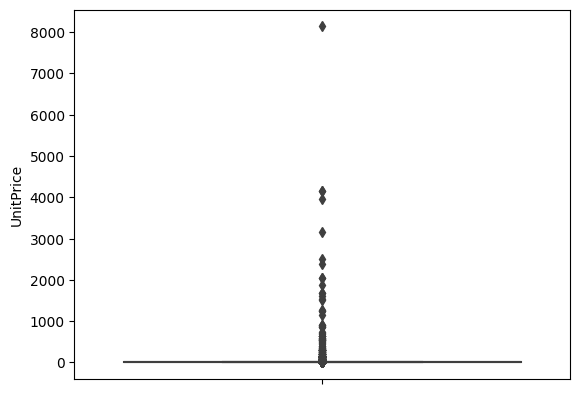

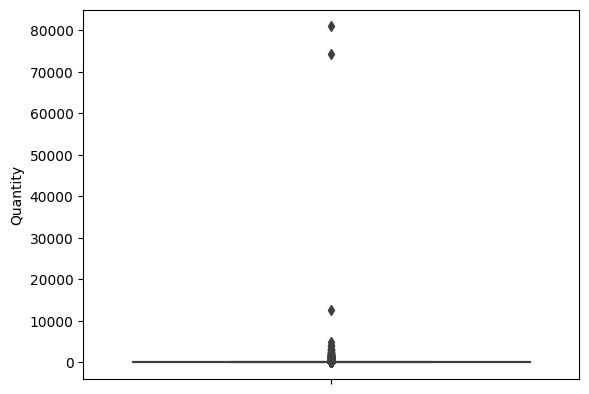

In [ ]:
for col in ['UnitPrice', 'Quantity']:
  sns.boxplot(data=df_cleaned5, y=col)
  plt.show()

Let's see the distribution of the data

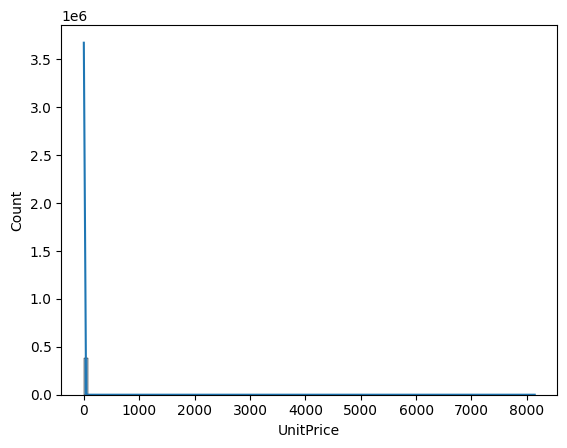

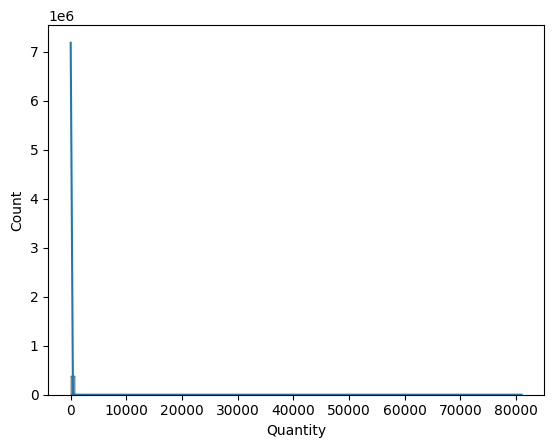

In [ ]:
for col in ['UnitPrice', 'Quantity']:
  sns.histplot(data=df_cleaned5, x=col, bins=100, kde=True)
  plt.show()

Let's checking using Interquartile Range

In [ ]:
def outlier(df, col):
  first_quartile = df[col].quantile(0.25)
  third_quartile = df[col].quantile(0.75)
  IQR = third_quartile - first_quartile
  lower = first_quartile - (1.5 * IQR)
  upper = third_quartile + (1.5 * IQR)
  outliers = df[(df[col] < lower) | (df[col] > upper)]
  print (outliers[['Description',  col]].sort_values(by=col, ascending=False))
  return outliers

In [ ]:
unitprice_outlier = outlier(df_cleaned5, 'UnitPrice')

                       Description  UnitPrice
17968                      POSTAGE    8142.75
188938                      Manual    4161.06
188937                      Manual    4161.06
188925                      Manual    3949.32
188905                      Manual    3155.95
...                            ...        ...
172953       GUMBALL MAGAZINE RACK       7.65
172951       GUMBALL MAGAZINE RACK       7.65
172950       GUMBALL MAGAZINE RACK       7.65
56890         RED DINER WALL CLOCK       7.65
146976  PICNIC BASKET WICKER LARGE       7.62

[34008 rows x 2 columns]


In [ ]:
len(unitprice_outlier) / len(df_cleaned5) * 100

8.767773122784401

In [ ]:
quantity_outlier = outlier(df_cleaned5, 'Quantity')

                                Description  Quantity
387874          PAPER CRAFT , LITTLE BIRDIE     80995
304303       MEDIUM CERAMIC TOP STORAGE JAR     74215
203029       ASSTD DESIGN 3D PAPER STICKERS     12540
201493    WORLD WAR 2 GLIDERS ASSTD DESIGNS      4800
60657                  SMALL POPCORN HOLDER      4300
...                                     ...       ...
37846    DOORMAT FANCY FONT HOME SWEET HOME        28
284944                 KITTY PENCIL ERASERS        28
219619         CHARLIE + LOLA BISCUITS TINS        28
348424  SET OF TEA COFFEE SUGAR TINS PANTRY        28
189259       CHRISTMAS PUDDING TRINKET POT         28

[25599 rows x 2 columns]


In [ ]:
len(quantity_outlier) / len(df_cleaned5) * 100

6.599806638736706

In [ ]:
df_cleaned5[df_cleaned5['UnitPrice'] > 1000][['StockCode', 'Description', 'UnitPrice']].sort_values('UnitPrice', ascending=False)

,StockCode,Description,UnitPrice
17968,POST,POSTAGE,8142.75
188938,M,Manual,4161.06
188937,M,Manual,4161.06
188925,M,Manual,3949.32
188905,M,Manual,3155.95
188878,M,Manual,2500.00
188803,M,Manual,2382.92
188804,M,Manual,2053.07
188889,M,Manual,2033.10
188808,M,Manual,1867.86


In [ ]:
df_cleaned5[df_cleaned5['UnitPrice'] > 100][['StockCode', 'Description', 'UnitPrice']].sort_values('UnitPrice')

,StockCode,Description,UnitPrice
298305,22823,CHEST NATURAL WOOD 20 DRAWERS,110.00
298304,22823,CHEST NATURAL WOOD 20 DRAWERS,110.00
298302,22823,CHEST NATURAL WOOD 20 DRAWERS,110.00
298295,22823,CHEST NATURAL WOOD 20 DRAWERS,110.00
298294,22823,CHEST NATURAL WOOD 20 DRAWERS,110.00
...,...,...,...
188905,M,Manual,3155.95
188925,M,Manual,3949.32
188937,M,Manual,4161.06
188938,M,Manual,4161.06


In [ ]:
df_cleaned5[df_cleaned5['UnitPrice'] > 50][['StockCode', 'Description', 'UnitPrice']].sort_values('UnitPrice')

,StockCode,Description,UnitPrice
218584,21769,VINTAGE POST OFFICE CABINET,52.77
296871,22929,SCHOOL DESK AND CHAIR,57.95
296863,22929,SCHOOL DESK AND CHAIR,57.95
305128,84632,DECORATIVE HANGING SHELVING UNIT,59.95
305127,84632,DECORATIVE HANGING SHELVING UNIT,59.95
...,...,...,...
188905,M,Manual,3155.95
188925,M,Manual,3949.32
188937,M,Manual,4161.06
188938,M,Manual,4161.06


In [ ]:
df_cleaned5[df_cleaned5['Description'] == 'Manual']['UnitPrice'].describe()

count     258.000000
mean      174.056279
std       596.570073
min         0.060000
25%         0.685000
50%         1.500000
75%        10.000000
max      4161.060000
Name: UnitPrice, dtype: float64

Both Unitprice and Quantity have a lot of outliers (based on IQR threshold). But, we can't treat them as outliers because we don't have actual data especially for product that has unit price with high standard deviation such as 'Manual'. We don't know what 'Manual' is . For clustering purpose in the next process we can handle outlier problem with scaling in the data preprocessing step.

#Data Preprocessing

## Feature Creation (Recency, Frequency, MonetaryValue)

Recency is just the number of days since the last transaction of the customer - the lower it is, the better, since every company wants its customers to be recent and active.

Frequency calculates the number of transactions in the last 12 months

 the monetary value is just the total value that the customer has spent with the company in the last 12 months

the 12 months is a standard way to do this, but it can be chosen arbitrarily depending on the business model and the lifecycle of the products and customers.

In [ ]:
df_cleaned5.head()

,InvoiceNo,StockCode,Description,CustomerID,Country,UnitPrice,InvoiceDate,Quantity
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,United Kingdom,4.25,2010-12-01 08:26:00,6
1,536373,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,United Kingdom,4.25,2010-12-01 09:02:00,6
2,536375,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,United Kingdom,4.25,2010-12-01 09:32:00,6
3,536396,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,United Kingdom,4.25,2010-12-01 10:51:00,6
4,536406,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,United Kingdom,4.25,2010-12-01 11:33:00,6


In this project, We'll do clustering based on Recency, Frequency, and Monetary Value. Therefore, We don't need StockCode, Description, and Country columns. We can just drop those columns.

In [ ]:
#Dropping unnecessary columns
drop_cols = ['StockCode', 'Description', 'Country']
df_rfm = df_cleaned5.drop(drop_cols, axis=1)
df_rfm

,InvoiceNo,CustomerID,UnitPrice,InvoiceDate,Quantity
0,536365,17850,4.25,2010-12-01 08:26:00,6
1,536373,17850,4.25,2010-12-01 09:02:00,6
2,536375,17850,4.25,2010-12-01 09:32:00,6
3,536396,17850,4.25,2010-12-01 10:51:00,6
4,536406,17850,4.25,2010-12-01 11:33:00,6
...,...,...,...,...,...
387870,580691,13790,0.29,2011-12-05 15:48:00,12
387871,580691,13790,0.29,2011-12-05 15:48:00,12
387872,580865,17914,0.19,2011-12-06 11:58:00,12
387873,581425,14796,0.19,2011-12-08 15:31:00,1


###Monetary Value

In [ ]:
#Getting monetary value
df_rfm['MonetaryValue'] = df_rfm['UnitPrice'] * df_rfm['Quantity']
df_rfm

,InvoiceNo,CustomerID,UnitPrice,InvoiceDate,Quantity,MonetaryValue
0,536365,17850,4.25,2010-12-01 08:26:00,6,25.50
1,536373,17850,4.25,2010-12-01 09:02:00,6,25.50
2,536375,17850,4.25,2010-12-01 09:32:00,6,25.50
3,536396,17850,4.25,2010-12-01 10:51:00,6,25.50
4,536406,17850,4.25,2010-12-01 11:33:00,6,25.50
...,...,...,...,...,...,...
387870,580691,13790,0.29,2011-12-05 15:48:00,12,3.48
387871,580691,13790,0.29,2011-12-05 15:48:00,12,3.48
387872,580865,17914,0.19,2011-12-06 11:58:00,12,2.28
387873,581425,14796,0.19,2011-12-08 15:31:00,1,0.19


###Recency and Frequency

In [ ]:
df_rfm['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [ ]:
df_rfm['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

The data starts from 2010-12-01 untill 2011-12-09. Let's assume the analysis is performed 2 days after the last purchase. We take 2 days to avoid zeros in Recency.

In [ ]:
#Getting current date
from datetime import datetime
current_date = datetime(2011,12,11)
print(current_date)

2011-12-11 00:00:00


In [ ]:
#Calculating recency, frequency, and monetary value for each customer
rfm = df_rfm.groupby('CustomerID').agg({'InvoiceDate' : lambda x: (current_date - x.max()).days,
                                        'InvoiceNo' : lambda x: x.nunique(),
                                        'MonetaryValue' : 'sum'})
rfm.columns = ['Recency', 'Frequency', 'MonetaryValue']
rfm

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,3,7,4310.00
12348,76,4,1806.84
12349,19,1,1757.55
12350,311,1,334.40
...,...,...,...
18280,278,1,180.60
18281,181,1,80.82
18282,8,2,178.05


In [ ]:
rfm.reset_index(inplace=True)
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     4339 non-null   object 
 1   Recency        4339 non-null   int64  
 2   Frequency      4339 non-null   int64  
 3   MonetaryValue  4339 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 135.7+ KB


##Exploratory Data Analysis

###Descriptive Statistics

In [ ]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,4339.000000,4339.000000,4339.000000
mean,93.041484,4.271952,2045.263983
std,100.007757,7.705493,8990.497308
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,305.955000
50%,51.000000,2.000000,664.000000
75%,142.500000,5.000000,1657.210000
max,374.000000,210.000000,280986.500000


###Correlation

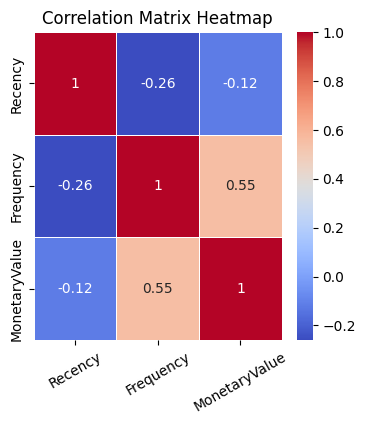

In [ ]:
corr_matrix = rfm[['Recency', 'Frequency', 'MonetaryValue']].corr()
plt.figure(figsize=(4,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=30)
plt.show()

There is a moderate correlation between Frequency and MonetaryValue. This correlation is expected, as customers tend to spend more when they make purchases more frequently.

###Boxplot

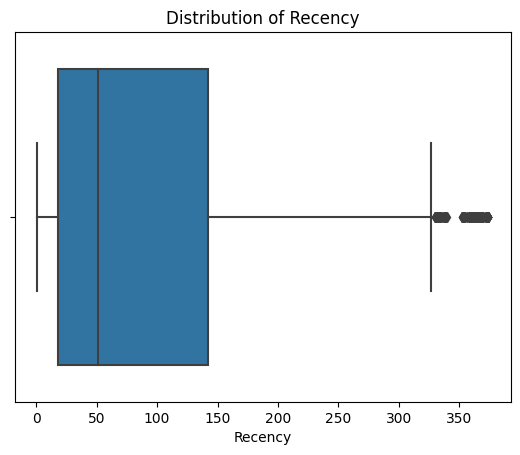

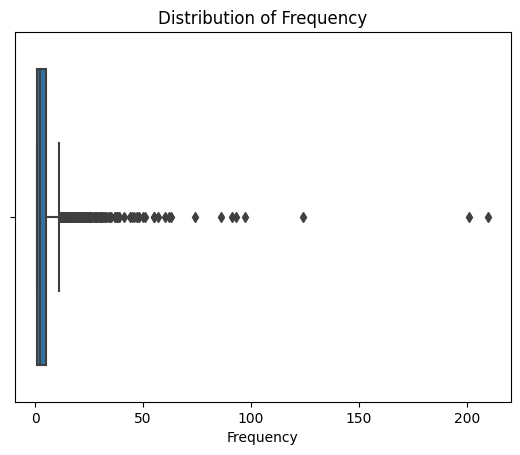

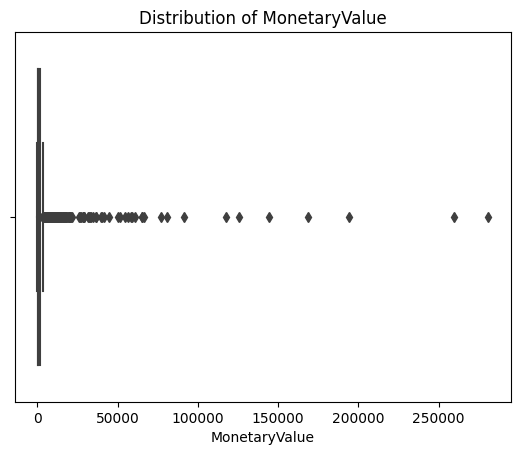

In [ ]:
for col in ['Recency', 'Frequency', 'MonetaryValue']:
  sns.boxplot(data=rfm, x=col)
  plt.title('Distribution of {}'.format(col))
  plt.show()

There are 'outliers' in every feature, we can handle that with scaling in the data transformation

###Distribution

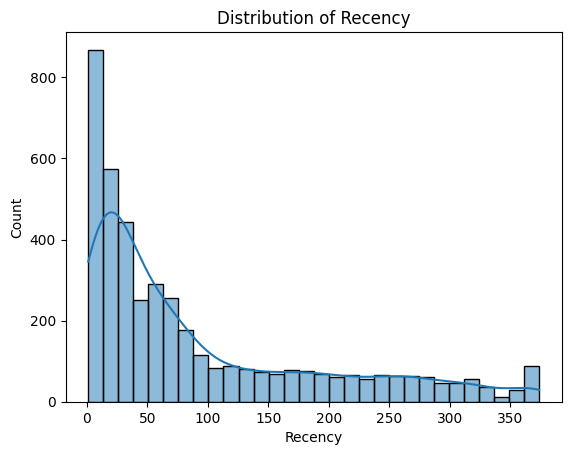

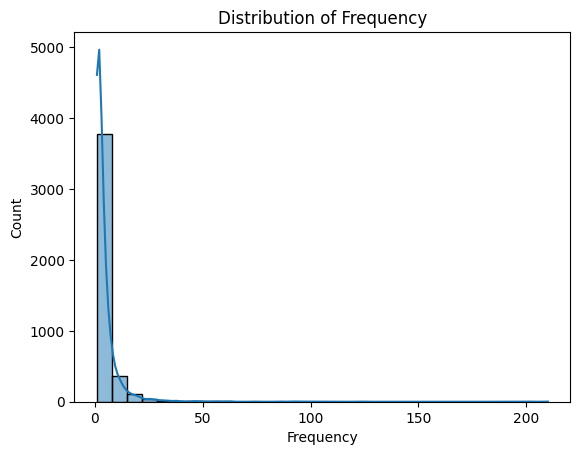

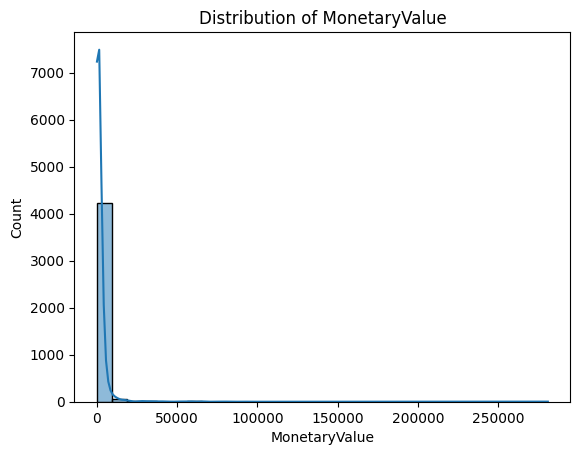

In [ ]:
#Checking the distribution for each feature
for col in ['Recency', 'Frequency', 'MonetaryValue']:
  sns.histplot(data=rfm, x=col, bins=30, kde=True)
  plt.title('Distribution of {}'.format(col))
  plt.show()

All features have right skewed distribution

## Data Transformation

We're gonna do clustering using KMeans. But, KMeans has some assumptions:

*   The first assumption is that all variables / features have symmetrical distributions (we have to unskewed the data)
*    The second assumption is that all variables have the same average values (we have to scale the data)



###Managing skewed data

First we have to extract only the features of the data

In [ ]:
#Extracting features
rfm_features = rfm[['Recency', 'Frequency', 'MonetaryValue']].values
rfm_features

array([[3.26000e+02, 1.00000e+00, 7.71836e+04],
       [3.00000e+00, 7.00000e+00, 4.31000e+03],
       [7.60000e+01, 4.00000e+00, 1.80684e+03],
       ...,
       [8.00000e+00, 2.00000e+00, 1.78050e+02],
       [4.00000e+00, 1.60000e+01, 2.00450e+03],
       [4.30000e+01, 3.00000e+00, 1.80968e+03]])

In [ ]:
rfm_features.shape

(4339, 3)

In [ ]:
type(rfm_features)

numpy.ndarray

Let's unskewed the data using logarithmic transformation

In [ ]:
rfm_unskewed = np.log(rfm_features)
rfm_unskewed

array([[ 5.78689738,  0.        , 11.25394228],
       [ 1.09861229,  1.94591015,  8.36869318],
       [ 4.33073334,  1.38629436,  7.49933474],
       ...,
       [ 2.07944154,  0.69314718,  5.18206441],
       [ 1.38629436,  2.77258872,  7.60314993],
       [ 3.76120012,  1.09861229,  7.50090531]])

In [ ]:
df_unskewed = pd.DataFrame(rfm_unskewed, columns=['Recency_log', 'Frequency_log', 'MonetaryValue_log'])
df_unskewed

,Recency_log,Frequency_log,MonetaryValue_log
0,5.786897,0.000000,11.253942
1,1.098612,1.945910,8.368693
2,4.330733,1.386294,7.499335
3,2.944439,0.000000,7.471676
4,5.739793,0.000000,5.812338
...,...,...,...
4334,5.627621,0.000000,5.196285
4335,5.198497,0.000000,4.392224
4336,2.079442,0.693147,5.182064
4337,1.386294,2.772589,7.603150


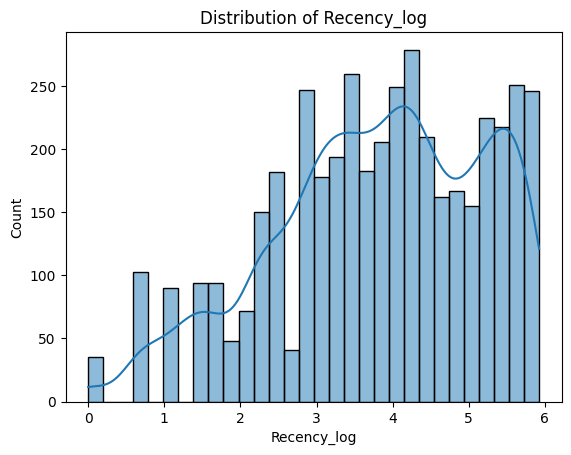

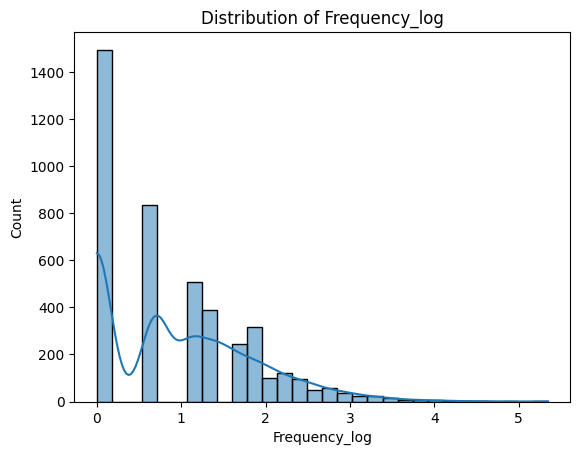

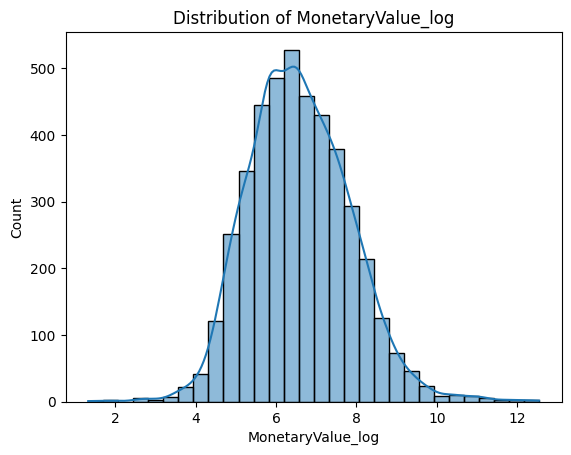

In [ ]:
#Checking the distribution for each feature
for col in list(df_unskewed.columns):
  sns.histplot(data=df_unskewed, x=col, bins=30, kde=True)
  plt.title('Distribution of {}'.format(col))
  plt.show()

We can see that the distribution for each feature seems normal

###Data Scaling

In [ ]:
df_unskewed.describe()

,Recency_log,Frequency_log,MonetaryValue_log
count,4339.000000,4339.000000,4339.000000
mean,3.800803,0.944320,6.582713
std,1.383560,0.900861,1.262451
min,0.000000,0.000000,1.321756
25%,2.890372,0.000000,5.723438
50%,3.931826,0.693147,6.498282
75%,4.959336,1.609438,7.412891
max,5.924256,5.347108,12.546062


the average values of all feature are different. So, we need to scale the data

In [ ]:
scaler=RobustScaler()
rfm_scaled = scaler.fit_transform(df_unskewed)

In [ ]:
rfm_scaled

array([[ 0.89661863, -0.43067656,  2.81491138],
       [-1.3693874 ,  0.7783854 ,  1.10711051],
       [ 0.19280553,  0.43067656,  0.59253064],
       ...,
       [-0.8953196 ,  0.        , -0.77907929],
       [-1.23034097,  1.29202967,  0.65397964],
       [-0.08246906,  0.25192964,  0.59346027]])

In [ ]:
rfm_scaled.mean(axis=0).round(2)

array([-0.06,  0.16,  0.05])

In [ ]:
rfm_scaled.std(axis=0).round(2)

array([0.67, 0.56, 0.75])

In [ ]:
df_scaling = pd.DataFrame(rfm_scaled, columns=['Recency_scaled', 'Frequency_scaled', 'MonetaryValue_scaled'])
df_scaling.describe()

,Recency_scaled,Frequency_scaled,MonetaryValue_scaled
count,4339.000000,4339.000000,4339.000000
mean,-0.063328,0.156062,0.049975
std,0.668721,0.559736,0.747254
min,-1.900384,-0.430677,-3.064025
25%,-0.503370,-0.430677,-0.458636
50%,0.000000,0.000000,0.000000
75%,0.496630,0.569323,0.541364
max,0.963009,2.891668,3.579727


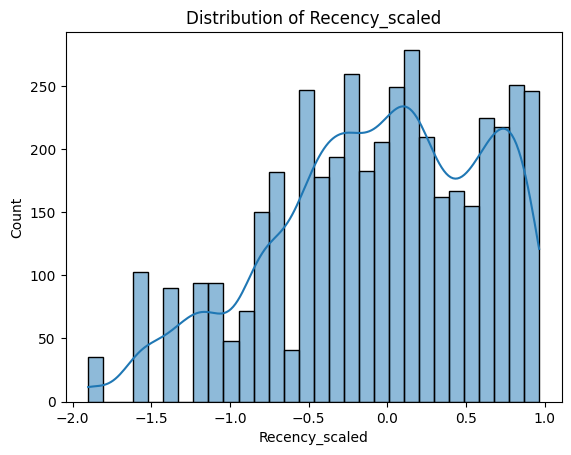

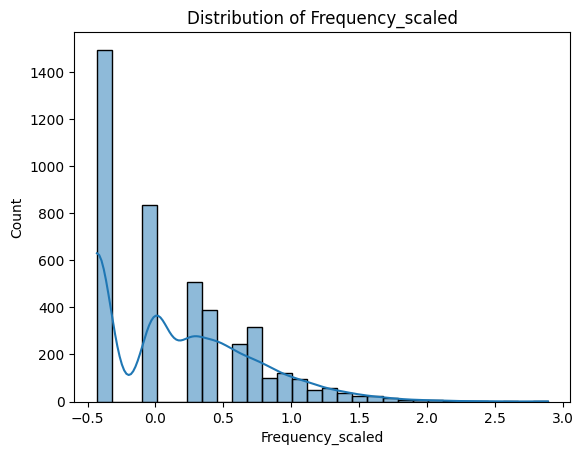

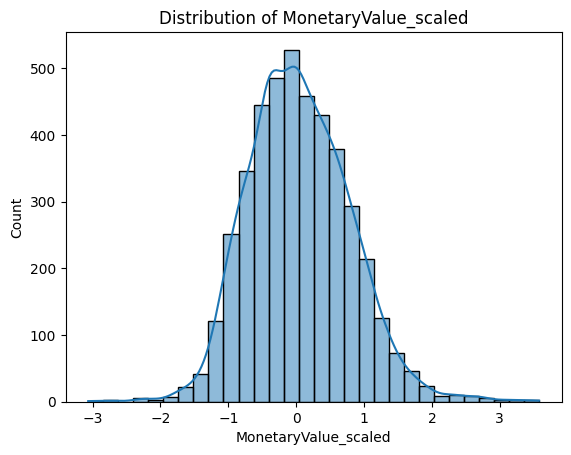

<Figure size 640x480 with 0 Axes>

In [ ]:
#Checking the distribution for each feature
for col in list(df_scaling.columns):
  sns.histplot(data=df_scaling, x=col, bins=30, kde=True)
  plt.title('Distribution of {}'.format(col))
  plt.show()
  plt.clf()

Now they have same average values (around zero). Let's do clustering!

# Data Clustering

## Determining number of cluster

###Elbow Method

The elbow method plots the sum of squared errors for each number of segments. The sum of squared errors is basically the sum of squared distances from each data point to their cluster center. We then look at the chart to identify where the decrease in SSE slows down and becomes somewhat marginal. That point looks like an elbow of a bended arm and it shows where there are diminishing returns by increasing the number of clusters. This point represents the optimal number of clusters from a sum-of-squared errors perspective

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

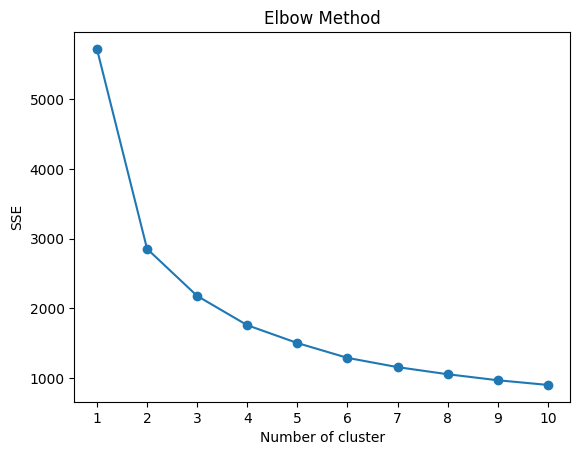

In [ ]:
#Fit KMeans and calculate SSE for each number of cluster (k)
sse=[]
ks = range(1,11)
for k in ks:
  kmeans = KMeans(n_clusters=k, random_state=51)
  kmeans.fit(rfm_scaled)
  sse.append(kmeans.inertia_)

#Plot SSE for each k
plt.title('Elbow Method')
plt.plot(ks, sse, '-o')
plt.xlabel('Number of cluster')
plt.ylabel('SSE')
plt.xticks(ks)
plt.show()

From the chart, we can see that 3 or 4 maybe the optimal number of cluster. Let's see another method which is silhouette analysis

###Silhouette analysis

 The silhouette score is a measure of how similar an object is to its own cluster (cohesion) and how different it is from other clusters (separation).

The silhouette score ranges from -1 to +1, where a high value signifies that our object is well clustered, and a low value points out a poor clustering choice.

In [ ]:
score = {}
ks = range(2, 11)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=51)
    clusters = kmeans.fit_predict(rfm_scaled)
    score[k] = silhouette_score(rfm_scaled, clusters)


sil_score = pd.DataFrame(list(score.items()), columns=['n_cluster', 'score'])
print(sil_score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

   n_cluster     score
0          2  0.426112
1          3  0.326596
2          4  0.332418
3          5  0.307799
4          6  0.306292
5          7  0.304789
6          8  0.280963
7          9  0.283234
8         10  0.279098


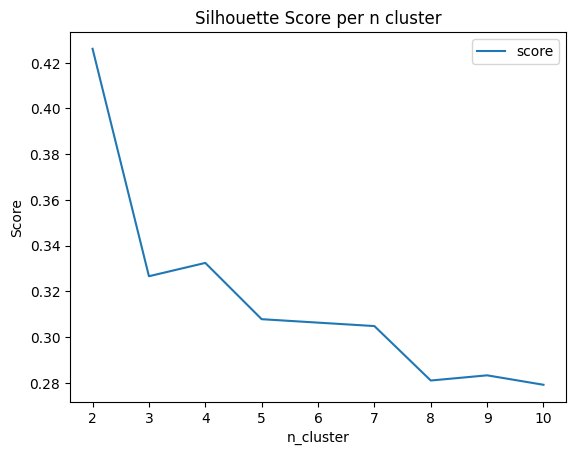

In [ ]:
sil_score.plot(x='n_cluster',
               y='score',
               kind='line')
plt.title('Silhouette Score per n cluster')
plt.ylabel('Score')
plt.show()

2 clusters has the highest silhouette score. 4 clusters has the second highest silhouette score and lower SSE than 2 clusters (from Elbow Method). Hence, I choose to use 4 clusters

##KMeans Clustering

In [ ]:
#data modelling
kmeans = KMeans(n_clusters=4, random_state=51)
kmeans.fit(rfm_scaled)
labels = kmeans.labels_

#assigning labels
rfm_labeled = rfm.assign(Cluster = labels)

rfm_labeled

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,CustomerID,Recency,Frequency,MonetaryValue,Cluster
0,12346,326,1,77183.60,0
1,12347,3,7,4310.00,2
2,12348,76,4,1806.84,0
3,12349,19,1,1757.55,3
4,12350,311,1,334.40,1
...,...,...,...,...,...
4334,18280,278,1,180.60,1
4335,18281,181,1,80.82,1
4336,18282,8,2,178.05,3
4337,18283,4,16,2004.50,2


In [ ]:
rfm_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     4339 non-null   object 
 1   Recency        4339 non-null   int64  
 2   Frequency      4339 non-null   int64  
 3   MonetaryValue  4339 non-null   float64
 4   Cluster        4339 non-null   int32  
dtypes: float64(1), int32(1), int64(2), object(1)
memory usage: 152.7+ KB


In [ ]:
#changing data type of Cluster to category
rfm_labeled['Cluster'] = rfm_labeled['Cluster'].astype('category')
rfm_labeled.dtypes

CustomerID         object
Recency             int64
Frequency           int64
MonetaryValue     float64
Cluster          category
dtype: object

##Evaluating & Interpreting Clustering Result

###Relative importance of cluster attributes

In general, we want our segments to differ from the overall population, and have distinctive properties of their own. We can use this technique to identify relative importance of each attribute. First, we calculate the average RFM values for each cluster. Then, we do the same for the total population. Finally, we divide the two, and subtract 1 from the result.
Subtracting 1 ensures 0 is returned when cluster average equals population average

The further that ratio is from zero, the more important that attribute is for defining a specific cluster compared to the population average

In [ ]:
#Dropping CustomerID column
rfm_numeric = rfm_labeled.drop('CustomerID', axis=1)

# Calculate average RFM values for each cluster
cluster_avg = rfm_numeric.groupby(['Cluster']).mean()


# Calculate average RFM values for the total customer population
population_avg = rfm_numeric.mean()


# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1


# Print relative importance scores rounded to 2 decimals
print(relative_imp.round(2))


         Recency  Frequency  MonetaryValue
Cluster                                   
0          -0.11      -0.11          -0.20
1           1.00      -0.70          -0.86
2          -0.87       1.94           2.62
3          -0.79      -0.50          -0.75


<ipython-input-74-5d6466b81732>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  population_avg = rfm_numeric.mean()


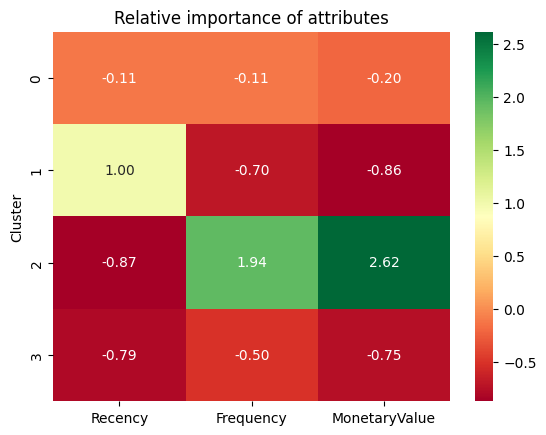

In [ ]:
# Add the plot title
plt.title('Relative importance of attributes')


# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()


###Descriptive Statistics

In [ ]:
rfm_cluster4 = rfm_labeled.groupby('Cluster').agg({'Recency':'mean',
                                    'Frequency':'mean',
                                    'MonetaryValue':'mean'}).round(2)
rfm_cluster4

,Recency,Frequency,MonetaryValue
Cluster,,,
0,83.21,3.82,1628.20
1,185.78,1.27,293.21
2,12.30,12.57,7399.25
3,19.26,2.12,504.31


In [ ]:
rfm_cluster_tot = rfm_labeled.groupby('Cluster').agg({'CustomerID':'count',
                                    'Frequency':'sum',
                                    'MonetaryValue':'sum'}).round(2)
rfm_cluster_tot

,CustomerID,Frequency,MonetaryValue
Cluster,,,
0,1251,4773,2036875.74
1,1476,1870,432776.64
2,811,10192,6000793.14
3,801,1701,403954.90


###Snake Plot

Snake plots are a market research visualization technique plotting segments and their RFM values on a line chart. We need to normalize the data so the values would be comparable. Finally, we plot each cluster's average values on a line plot.

In [ ]:
df_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
df_scaled['Cluster'] = rfm_labeled['Cluster']
df_scaled.head()

,Recency,Frequency,Monetary,Cluster
0,0.896619,-0.430677,2.814911,0
1,-1.369387,0.778385,1.107111,2
2,0.192806,0.430677,0.592531,0
3,-0.477237,-0.430677,0.576159,3
4,0.873851,-0.430677,-0.406016,1


For easier plotting, we will melt the dataset into a long format. We basically melt the three RFM columns and create one called attribute. The attribute column will store the name of the metric, and then store its value into another column.

In [ ]:
df_melt = pd.melt(df_scaled,
                  id_vars ='Cluster',
                  value_vars = ['Recency', 'Frequency', 'Monetary'],
                  var_name='Attribute',
                  value_name='Value')
df_melt

,Cluster,Attribute,Value
0,0,Recency,0.896619
1,2,Recency,-1.369387
2,0,Recency,0.192806
3,3,Recency,-0.477237
4,1,Recency,0.873851
...,...,...,...
13012,1,Monetary,-0.770662
13013,1,Monetary,-1.246592
13014,3,Monetary,-0.779079
13015,2,Monetary,0.653980


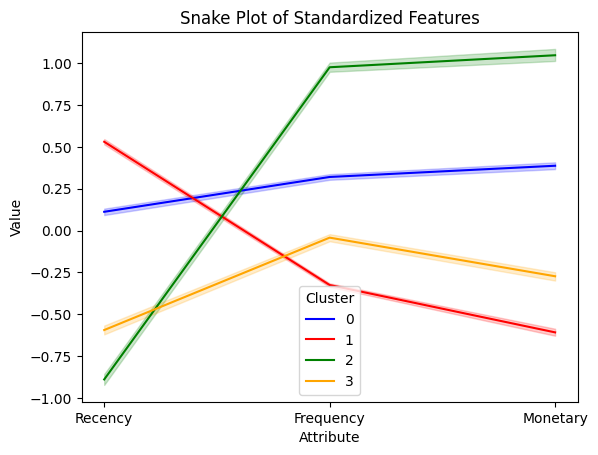

In [ ]:
plt.title('Snake Plot of Standardized Features')
sns.lineplot(x='Attribute',
             y='Value',
             hue='Cluster',
             data=df_melt,
             palette=['blue', 'red', 'green', 'orange'])
plt.show()

*   0: 3 2 2
*   1: 4 4 4
*   2: 1 1 1
*   3: 2 3 3

###Box Plot

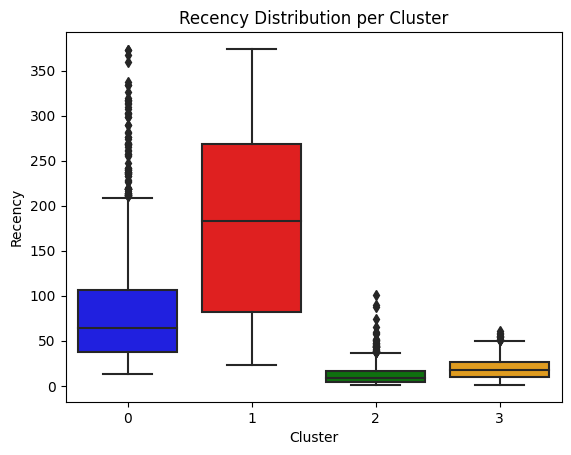

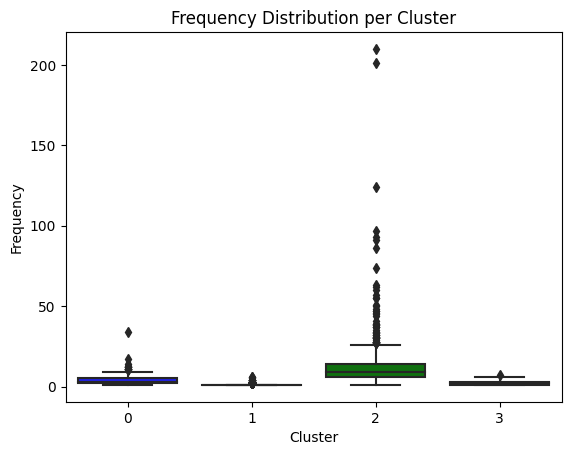

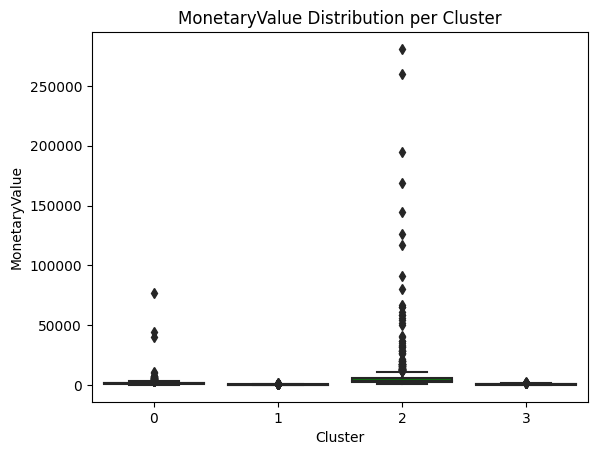

In [ ]:
for col in ['Recency', 'Frequency', 'MonetaryValue']:
  plt.title('{} Distribution per Cluster'.format(col))
  sns.boxplot(data=rfm_labeled,
              x='Cluster',
              y=col,
              palette=['blue', 'red', 'green', 'orange'])
  plt.show()

Including outliers by setting whis=[0, 100] (min and max value)

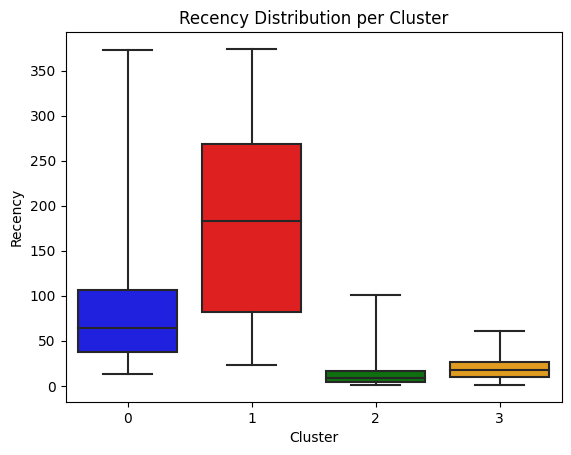

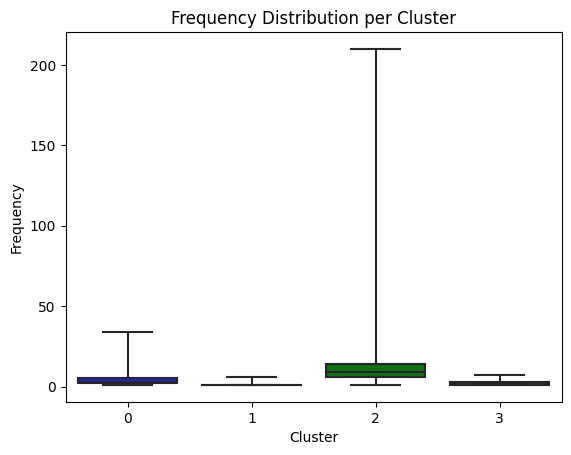

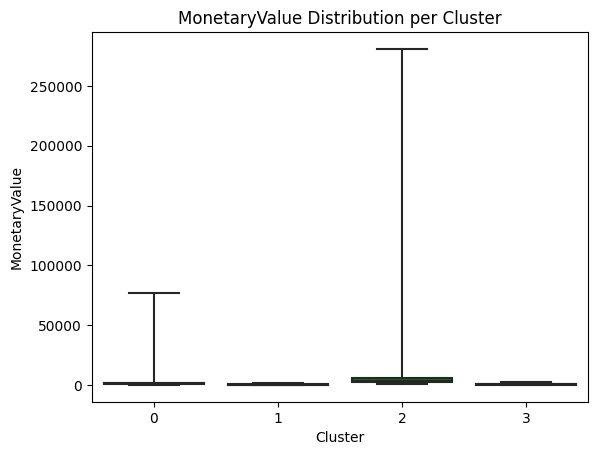

In [ ]:
for col in ['Recency', 'Frequency', 'MonetaryValue']:
  plt.title('{} Distribution per Cluster'.format(col))
  sns.boxplot(data=rfm_labeled,
              x='Cluster',
              y=col,
              whis=[0, 100],
              palette=['blue', 'red', 'green', 'orange'])
  plt.show()

Excluding outliers by setting sym=' '

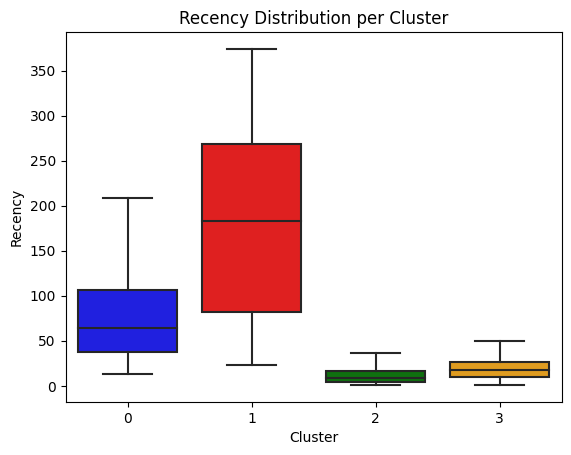

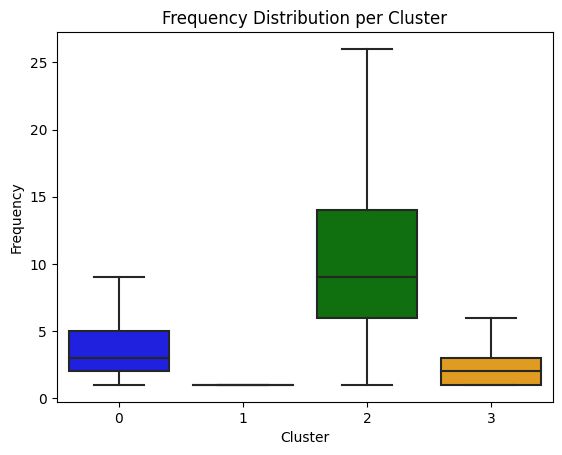

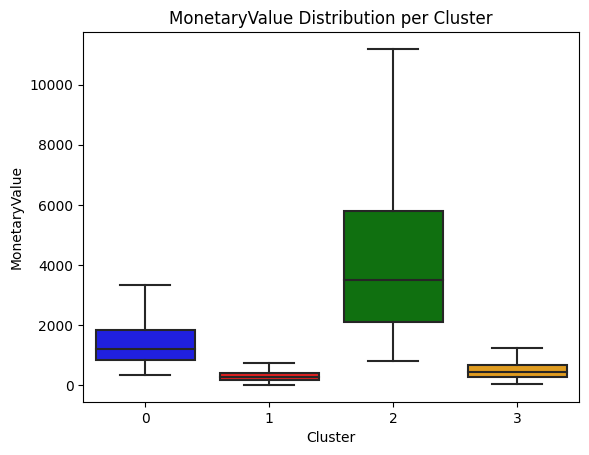

In [ ]:
for col in ['Recency', 'Frequency', 'MonetaryValue']:
  plt.title('{} Distribution per Cluster'.format(col))
  sns.boxplot(data=rfm_labeled,
              x='Cluster',
              y=col,
              sym='',
              palette=['blue', 'red', 'green', 'orange'])
  plt.show()

###Pie Chart

####Number of Customer

In [ ]:
cluster_count = rfm_labeled['Cluster'].value_counts().reset_index()
cluster_count.columns=['Cluster', 'Number of Customer']
cluster_count

,Cluster,Number of Customer
0,1,1476
1,0,1251
2,2,811
3,3,801


In [ ]:
cluster_percentage = rfm_labeled['Cluster'].value_counts(normalize=True).reset_index()
cluster_percentage.columns=['Cluster', 'Percentage of Customer']
cluster_percentage

,Cluster,Percentage of Customer
0,1,0.340171
1,0,0.288315
2,2,0.186909
3,3,0.184605


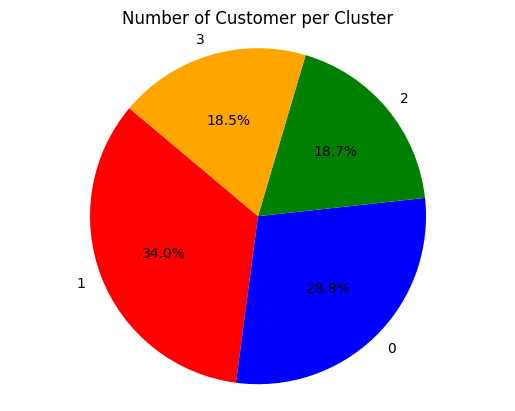

In [ ]:
# Counting number of customer per cluster
cluster_counts = rfm_labeled['Cluster'].value_counts()

# Making pie chart
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=['red', 'blue', 'green', 'orange'])
plt.axis('equal')  # Agar pie chart menjadi lingkaran
plt.title('Number of Customer per Cluster')
plt.show()


####Purchase Frequency

  Cluster  Frequency
0       0       4773
1       1       1870
2       2      10192
3       3       1701 



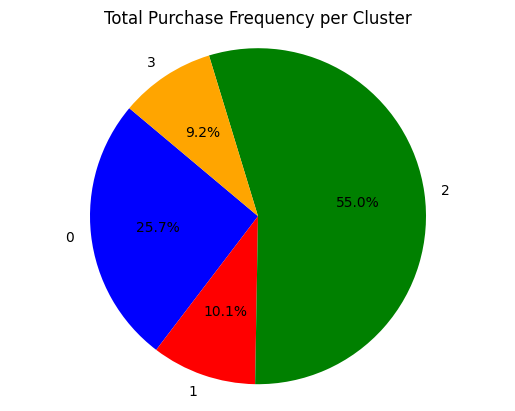

In [ ]:
# Counting Total Purchase Frequency per cluster
cluster_freq = rfm_labeled.groupby('Cluster')['Frequency'].sum()
print(cluster_freq.reset_index(), '\n')

# Making pie chart
plt.pie(cluster_freq, labels=cluster_freq.index, autopct='%1.1f%%', startangle=140, colors=['blue', 'red', 'green', 'orange'])
plt.axis('equal')  # Agar pie chart menjadi lingkaran
plt.title('Total Purchase Frequency per Cluster')
plt.show()

####Monetary

  Cluster  MonetaryValue
0       0    2036875.742
1       1     432776.641
2       2    6000793.141
3       3     403954.900 



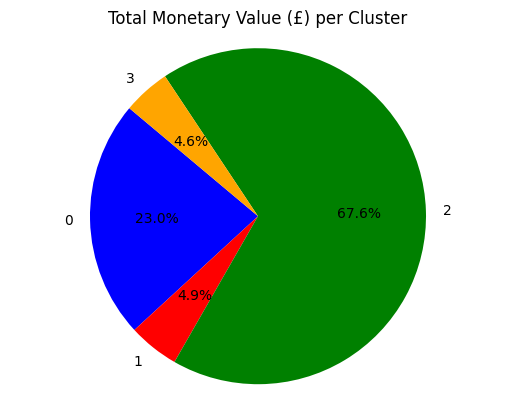

In [ ]:
# Counting Total Monetary Value per cluster
cluster_money = rfm_labeled.groupby('Cluster')['MonetaryValue'].sum()
print(cluster_money.reset_index(), '\n')

# Making pie chart
plt.pie(cluster_money, labels=cluster_money.index, autopct='%1.1f%%', startangle=140, colors=['blue', 'red', 'green', 'orange'])
plt.axis('equal')  # Agar pie chart menjadi lingkaran
plt.title('Total Monetary Value (£) per Cluster')
plt.show()

###Bar Plot

In [ ]:
df_labeled = pd.merge(df_cleaned5, rfm_labeled[['CustomerID', 'Cluster']], on = 'CustomerID', how='left')
df_labeled.drop('Country', axis=1, inplace=True)
df_labeled

,InvoiceNo,StockCode,Description,CustomerID,UnitPrice,InvoiceDate,Quantity,Cluster
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,4.25,2010-12-01 08:26:00,6,0
1,536373,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,4.25,2010-12-01 09:02:00,6,0
2,536375,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,4.25,2010-12-01 09:32:00,6,0
3,536396,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,4.25,2010-12-01 10:51:00,6,0
4,536406,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,4.25,2010-12-01 11:33:00,6,0
...,...,...,...,...,...,...,...,...
387870,580691,90214W,"LETTER ""W"" BLING KEY RING",13790,0.29,2011-12-05 15:48:00,12,3
387871,580691,90214Z,"LETTER ""Z"" BLING KEY RING",13790,0.29,2011-12-05 15:48:00,12,3
387872,580865,90089,PINK CRYSTAL SKULL PHONE CHARM,17914,0.19,2011-12-06 11:58:00,12,3
387873,581425,90089,PINK CRYSTAL SKULL PHONE CHARM,14796,0.19,2011-12-08 15:31:00,1,2


In [ ]:
df_labeled['TotalSpend'] = df_labeled['Quantity'] * df_labeled['UnitPrice']
df_labeled['InvoiceMonth'] = df_labeled['InvoiceDate'].dt.to_period('M')
df_labeled

,InvoiceNo,StockCode,Description,CustomerID,UnitPrice,InvoiceDate,Quantity,Cluster,TotalSpend,InvoiceMonth
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,4.25,2010-12-01 08:26:00,6,0,25.50,2010-12
1,536373,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,4.25,2010-12-01 09:02:00,6,0,25.50,2010-12
2,536375,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,4.25,2010-12-01 09:32:00,6,0,25.50,2010-12
3,536396,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,4.25,2010-12-01 10:51:00,6,0,25.50,2010-12
4,536406,21730,GLASS STAR FROSTED T-LIGHT HOLDER,17850,4.25,2010-12-01 11:33:00,6,0,25.50,2010-12
...,...,...,...,...,...,...,...,...,...,...
387870,580691,90214W,"LETTER ""W"" BLING KEY RING",13790,0.29,2011-12-05 15:48:00,12,3,3.48,2011-12
387871,580691,90214Z,"LETTER ""Z"" BLING KEY RING",13790,0.29,2011-12-05 15:48:00,12,3,3.48,2011-12
387872,580865,90089,PINK CRYSTAL SKULL PHONE CHARM,17914,0.19,2011-12-06 11:58:00,12,3,2.28,2011-12
387873,581425,90089,PINK CRYSTAL SKULL PHONE CHARM,14796,0.19,2011-12-08 15:31:00,1,2,0.19,2011-12


In [ ]:
monthly = df_labeled.groupby(['InvoiceMonth', 'Cluster']).agg({'CustomerID':'nunique',
                                                               'InvoiceNo':'nunique',
                                                               'TotalSpend': 'sum'}).reset_index()
monthly

,InvoiceMonth,Cluster,CustomerID,InvoiceNo,TotalSpend
0,2010-12,0,249,358,119394.430
1,2010-12,1,180,189,41180.740
2,2010-12,2,389,783,392597.770
3,2010-12,3,67,70,15755.530
4,2011-01,0,246,280,204704.720
5,2011-01,1,121,130,29846.740
6,2011-01,2,345,547,326210.070
7,2011-01,3,29,30,6314.120
8,2011-02,0,260,299,111922.060
9,2011-02,1,139,145,35625.720


####Number of Customer

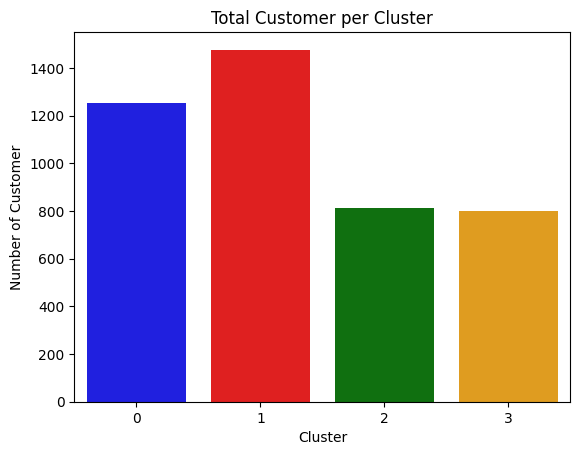

In [ ]:
sns.countplot(data = rfm_labeled,
              x = 'Cluster',
              palette=['blue', 'red', 'green', 'orange'])
plt.title('Total Customer per Cluster')
plt.ylabel('Number of Customer')
plt.show()

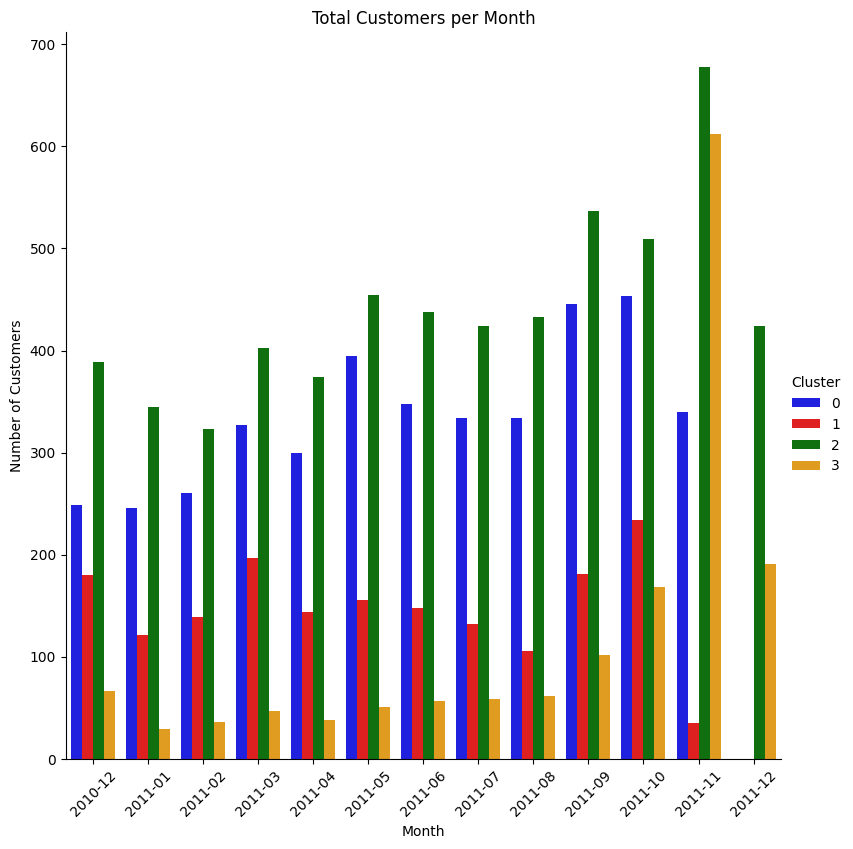

In [ ]:
sns.catplot(data=monthly,
            x='InvoiceMonth',
            y='CustomerID',
            kind='bar',
            hue='Cluster',
            errorbar=None,
            height=8,
            palette=['blue', 'red', 'green', 'orange'])
plt.title('Total Customers per Month')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

####Recency

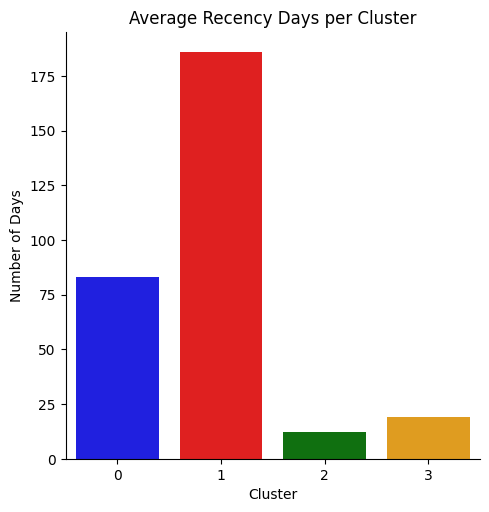

In [ ]:
sns.catplot(data = rfm_labeled,
            y = 'Recency',
            x = 'Cluster',
            kind = 'bar',
            errorbar = None,
            estimator = 'mean',
            palette=['blue', 'red', 'green', 'orange'])
plt.title('Average Recency Days per Cluster')
plt.ylabel('Number of Days')
plt.show()

In [ ]:
rfm_labeled.groupby('Cluster').agg({'Recency' : ['min', 'median', 'mean', 'max']}).reset_index()

Cluster Recency                        
              min median        mean  max
0       0      13   64.0   83.208633  373
1       1      23  183.0  185.775068  374
2       2       1    9.0   12.304562  101
3       3       1   18.0   19.263421   61

####Purchase Frequency

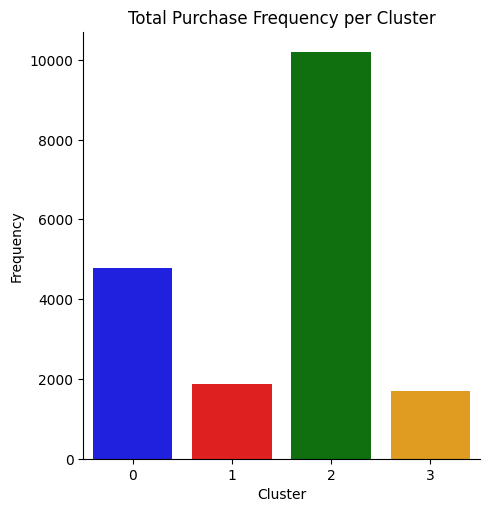

In [ ]:
sns.catplot(data = rfm_labeled,
            y = 'Frequency',
            x = 'Cluster',
            kind = 'bar',
            errorbar = None,
            estimator = 'sum',
            palette=['blue', 'red', 'green', 'orange'])
plt.title('Total Purchase Frequency per Cluster')
plt.show()

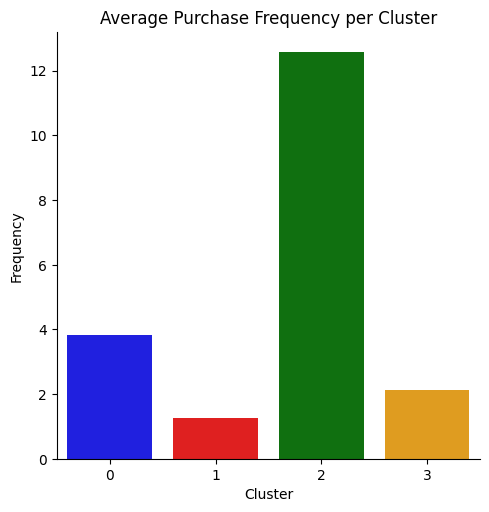

In [ ]:
sns.catplot(data = rfm_labeled,
            y = 'Frequency',
            x = 'Cluster',
            kind = 'bar',
            errorbar = None,
            estimator = 'mean',
            palette=['blue', 'red', 'green', 'orange'])
plt.title('Average Purchase Frequency per Cluster')
plt.show()

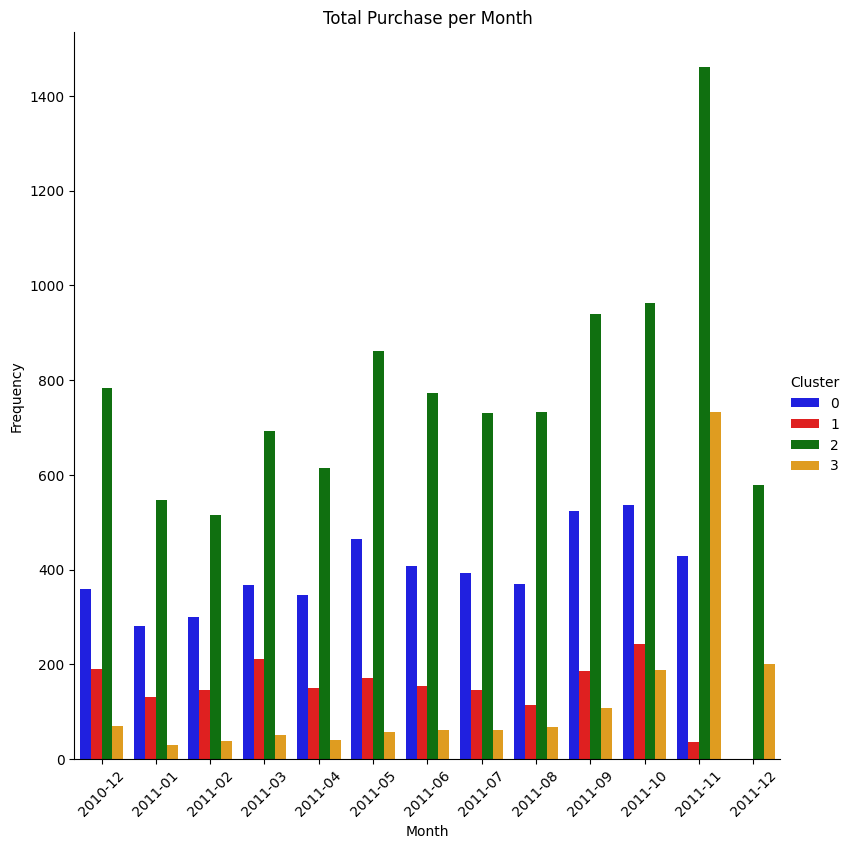

In [ ]:
sns.catplot(data=monthly,
            x='InvoiceMonth',
            y='InvoiceNo',
            kind='bar',
            hue='Cluster',
            errorbar=None,
            height=8,
            palette=['blue', 'red', 'green', 'orange'])
plt.title('Total Purchase per Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
def top10_product_order(i, color):
  cluster = df_labeled['Cluster'] == i
  df = df_labeled[cluster].groupby(['StockCode', 'Description'])['InvoiceNo'].nunique().sort_values(ascending=False).reset_index()[:10]
  df.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)

  sns.catplot(data=df,
              x='Frequency',
              y='StockCode',
              kind='bar',
              errorbar=None,
              palette=[color])
  plt.title('Cluster {} Top 10 Purchased Product'.format(i))
  plt.show()

  print('\n')
  return df

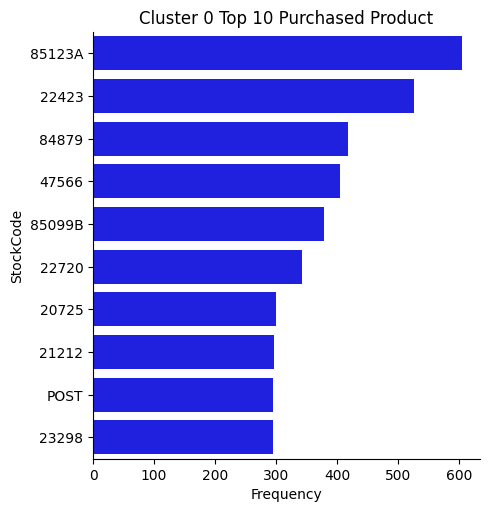

,StockCode,Description,Frequency
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,604
1,22423,REGENCY CAKESTAND 3 TIER,526
2,84879,ASSORTED COLOUR BIRD ORNAMENT,418
3,47566,PARTY BUNTING,405
4,85099B,JUMBO BAG RED RETROSPOT,379
5,22720,SET OF 3 CAKE TINS PANTRY DESIGN,342
6,20725,LUNCH BAG RED RETROSPOT,300
7,21212,PACK OF 72 RETROSPOT CAKE CASES,297
8,POST,POSTAGE,295
9,23298,SPOTTY BUNTING,295


In [ ]:
cluster0_top10 = top10_product_order(0, 'blue')
cluster0_top10

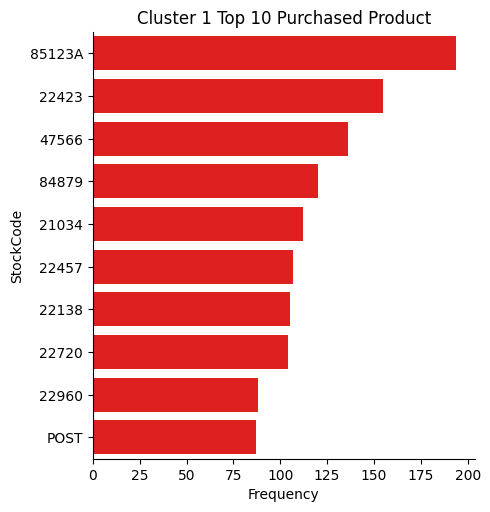

,StockCode,Description,Frequency
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,194
1,22423,REGENCY CAKESTAND 3 TIER,155
2,47566,PARTY BUNTING,136
3,84879,ASSORTED COLOUR BIRD ORNAMENT,120
4,21034,REX CASH+CARRY JUMBO SHOPPER,112
5,22457,NATURAL SLATE HEART CHALKBOARD,107
6,22138,BAKING SET 9 PIECE RETROSPOT,105
7,22720,SET OF 3 CAKE TINS PANTRY DESIGN,104
8,22960,JAM MAKING SET WITH JARS,88
9,POST,POSTAGE,87


In [ ]:
cluster1_top10 = top10_product_order(1, 'red')
cluster1_top10

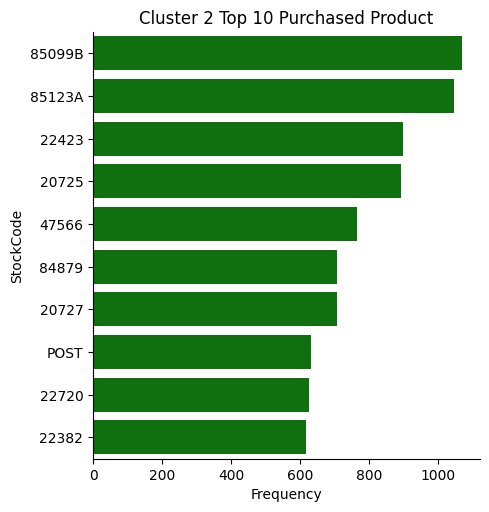

,StockCode,Description,Frequency
0,85099B,JUMBO BAG RED RETROSPOT,1067
1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1046
2,22423,REGENCY CAKESTAND 3 TIER,897
3,20725,LUNCH BAG RED RETROSPOT,891
4,47566,PARTY BUNTING,764
5,84879,ASSORTED COLOUR BIRD ORNAMENT,706
6,20727,LUNCH BAG BLACK SKULL.,705
7,POST,POSTAGE,631
8,22720,SET OF 3 CAKE TINS PANTRY DESIGN,624
9,22382,LUNCH BAG SPACEBOY DESIGN,617


In [ ]:
cluster2_top10 = top10_product_order(2, 'green')
cluster2_top10

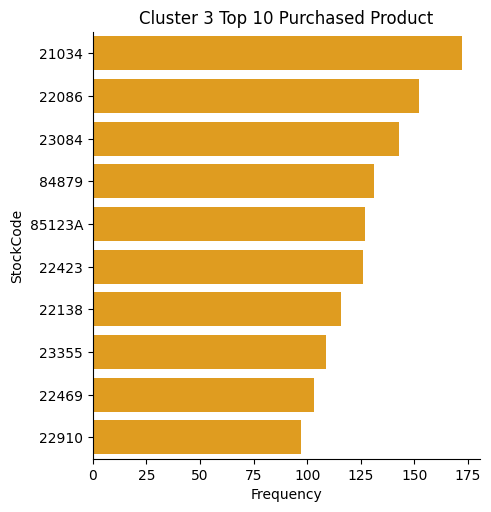

,StockCode,Description,Frequency
0,21034,REX CASH+CARRY JUMBO SHOPPER,172
1,22086,PAPER CHAIN KIT 50'S CHRISTMAS,152
2,23084,RABBIT NIGHT LIGHT,143
3,84879,ASSORTED COLOUR BIRD ORNAMENT,131
4,85123A,WHITE HANGING HEART T-LIGHT HOLDER,127
5,22423,REGENCY CAKESTAND 3 TIER,126
6,22138,BAKING SET 9 PIECE RETROSPOT,116
7,23355,HOT WATER BOTTLE KEEP CALM,109
8,22469,HEART OF WICKER SMALL,103
9,22910,PAPER CHAIN KIT VINTAGE CHRISTMAS,97


In [ ]:
cluster3_top10 = top10_product_order(3, 'orange')
cluster3_top10

####Monetary

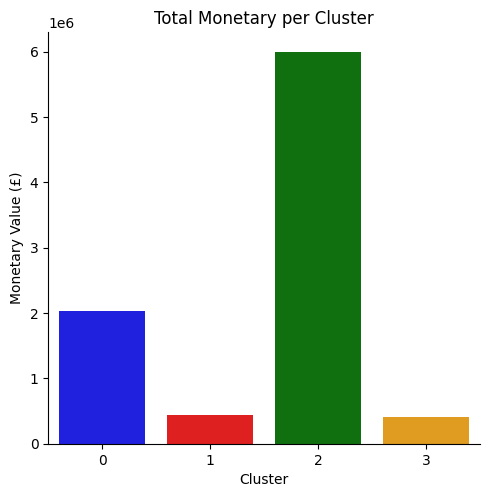

In [ ]:
sns.catplot(data = rfm_labeled,
            y = 'MonetaryValue',
            x = 'Cluster',
            kind = 'bar',
            errorbar = None,
            estimator = 'sum',
            palette=['blue', 'red', 'green', 'orange'])
plt.ylabel('Monetary Value (£)')
plt.title('Total Monetary per Cluster')
plt.show()

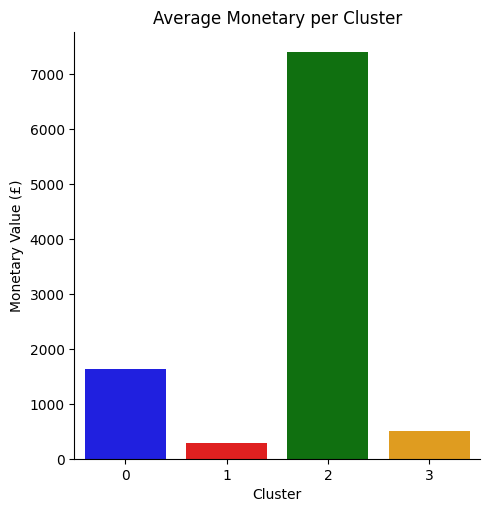

In [ ]:
sns.catplot(data = rfm_labeled,
            y = 'MonetaryValue',
            x = 'Cluster',
            kind = 'bar',
            errorbar = None,
            estimator = 'mean',
            palette=['blue', 'red', 'green', 'orange'])
plt.ylabel('Monetary Value (£)')
plt.title('Average Monetary per Cluster')
plt.show()

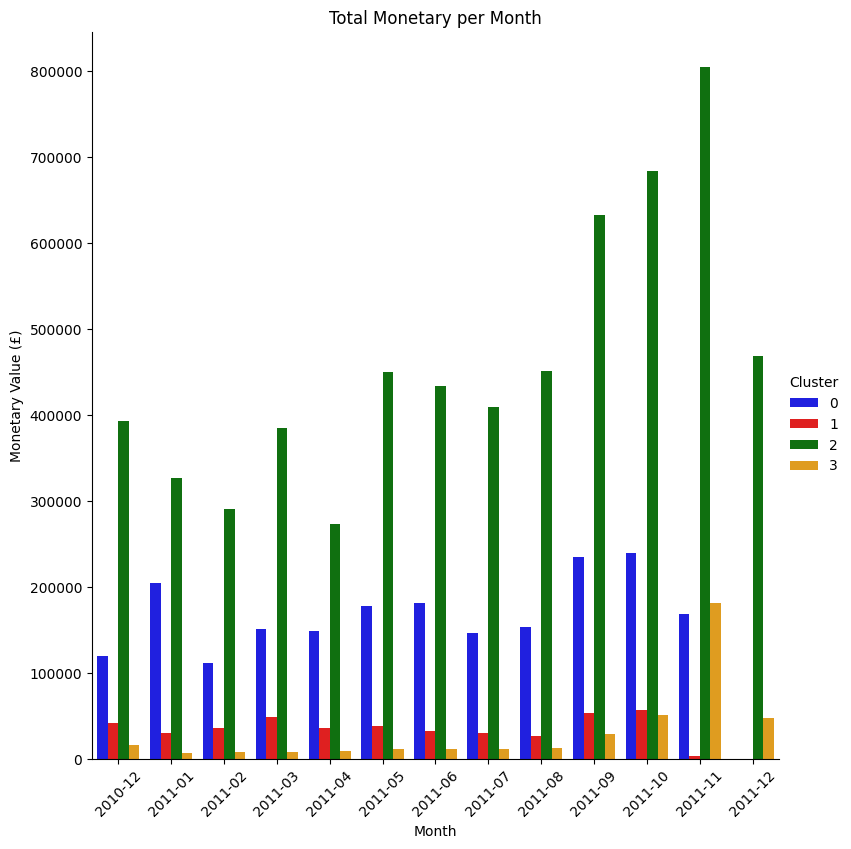

In [ ]:
sns.catplot(data=monthly,
            x='InvoiceMonth',
            y='TotalSpend',
            kind='bar',
            hue='Cluster',
            errorbar=None,
            height=8,
            palette=['blue', 'red', 'green', 'orange'])
plt.title('Total Monetary per Month')
plt.xlabel('Month')
plt.ylabel('Monetary Value (£)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
def top10_product_monetary(i, color):
  cluster = df_labeled['Cluster'] == i
  df = df_labeled[cluster].groupby(['StockCode', 'Description'])['TotalSpend'].sum().sort_values(ascending=False).reset_index()[:10]
  df.rename(columns={'TotalSpend': 'Monetary Value (£)'}, inplace=True)

  sns.catplot(data=df,
              x='Monetary Value (£)',
              y='StockCode',
              kind='bar',
              errorbar=None,
              palette=[color])
  plt.title('Cluster {} Top 10 Product by Monetary Value'.format(i))
  plt.xticks(rotation=35)
  plt.show()

  print('\n')
  return df

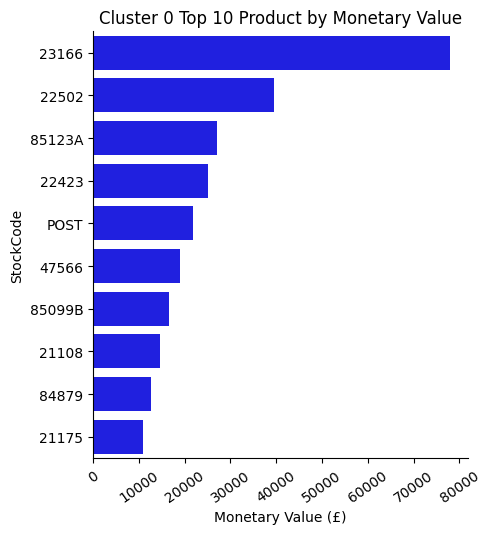

,StockCode,Description,Monetary Value (£)
0,23166,MEDIUM CERAMIC TOP STORAGE JAR,78027.03
1,22502,PICNIC BASKET WICKER 60 PIECES,39619.50
2,85123A,WHITE HANGING HEART T-LIGHT HOLDER,27145.35
3,22423,REGENCY CAKESTAND 3 TIER,25144.15
4,POST,POSTAGE,21874.39
5,47566,PARTY BUNTING,18891.05
6,85099B,JUMBO BAG RED RETROSPOT,16548.61
7,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,14602.71
8,84879,ASSORTED COLOUR BIRD ORNAMENT,12656.32
9,21175,GIN + TONIC DIET METAL SIGN,10824.24


In [ ]:
top10_cluster0 = top10_product_monetary(0, 'blue')
top10_cluster0

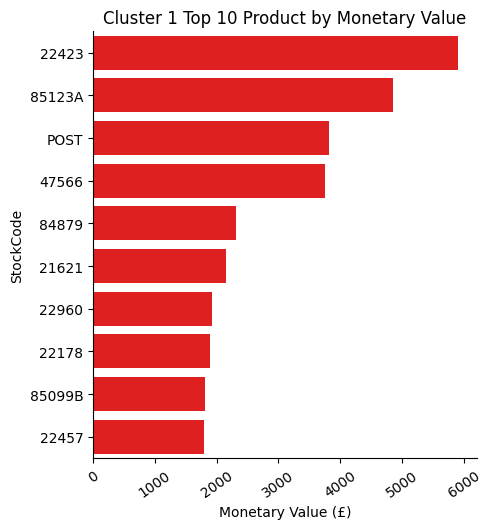

,StockCode,Description,Monetary Value (£)
0,22423,REGENCY CAKESTAND 3 TIER,5910.75
1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,4859.35
2,POST,POSTAGE,3821.90
3,47566,PARTY BUNTING,3749.00
4,84879,ASSORTED COLOUR BIRD ORNAMENT,2308.54
5,21621,VINTAGE UNION JACK BUNTING,2156.00
6,22960,JAM MAKING SET WITH JARS,1920.50
7,22178,VICTORIAN GLASS HANGING T-LIGHT,1887.73
8,85099B,JUMBO BAG RED RETROSPOT,1815.34
9,22457,NATURAL SLATE HEART CHALKBOARD,1799.50


In [ ]:
top10_cluster1 = top10_product_monetary(1, 'red')
top10_cluster1

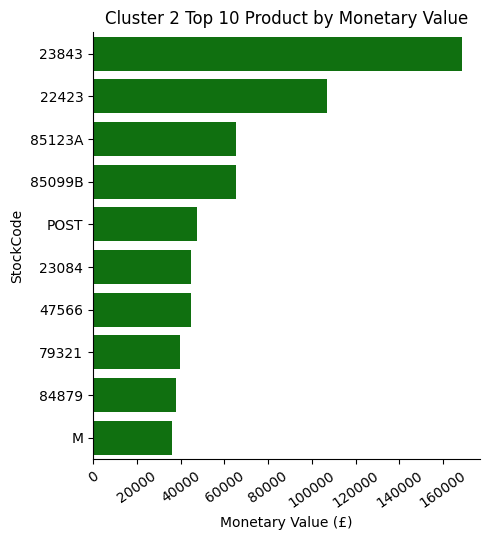

,StockCode,Description,Monetary Value (£)
0,23843,"PAPER CRAFT , LITTLE BIRDIE",168469.60
1,22423,REGENCY CAKESTAND 3 TIER,107055.90
2,85123A,WHITE HANGING HEART T-LIGHT HOLDER,65484.75
3,85099B,JUMBO BAG RED RETROSPOT,65248.25
4,POST,POSTAGE,47552.72
5,23084,RABBIT NIGHT LIGHT,44898.87
6,47566,PARTY BUNTING,44653.28
7,79321,CHILLI LIGHTS,39764.81
8,84879,ASSORTED COLOUR BIRD ORNAMENT,37799.74
9,M,Manual,35933.20


In [ ]:
top10_cluster2 = top10_product_monetary(2, 'green')
top10_cluster2

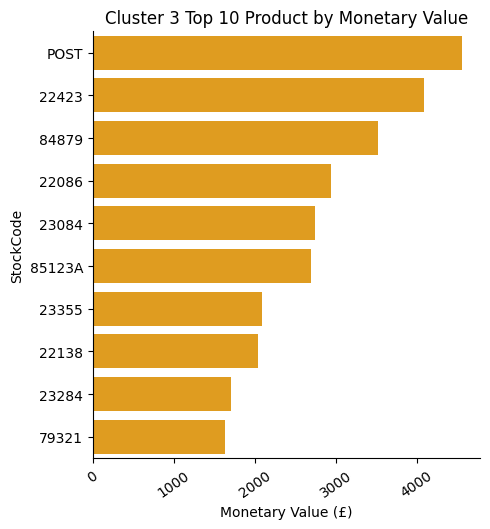

,StockCode,Description,Monetary Value (£)
0,POST,POSTAGE,4554.95
1,22423,REGENCY CAKESTAND 3 TIER,4093.50
2,84879,ASSORTED COLOUR BIRD ORNAMENT,3519.99
3,22086,PAPER CHAIN KIT 50'S CHRISTMAS,2942.95
4,23084,RABBIT NIGHT LIGHT,2745.63
5,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2696.15
6,23355,HOT WATER BOTTLE KEEP CALM,2085.15
7,22138,BAKING SET 9 PIECE RETROSPOT,2037.45
8,23284,DOORMAT KEEP CALM AND COME IN,1711.50
9,79321,CHILLI LIGHTS,1627.40


In [ ]:
top10_cluster3 = top10_product_monetary(3, 'orange')
top10_cluster3

#Analysis

Based on average values for each cluster, Cluster 2 is the most valuable customers that have highest RFM values. Otherwise, Cluster 1 is the most at risk customers that have lowest RFM values. Cluster 3 is more recent than Cluster 0, but it has lower Frequency and Monetary Value than Cluster 0

Cluster 1 has the the highest number of customers (34%). But, Cluster 1 along with Cluster 3 have the least impact on company’s revenue (4.6% - 4.9%). Cluster 3 is more recent than Cluster 1. Cluster 2 along with Cluster 3 have the lowest number of customers (18.5% - 18.7%), but Cluster 2 has the most significant impact on the company’s revenue (67.6%). Cluster 0 has moderate number of customers (28.8%) and impact on the company’s revenue (23%), but it has high range of recency days and It is less recent than Cluster 2 and Cluster 3.


#Conclusion and Recommendation

##Conclusion
- Cluster 0: Customers who have spent a good amount but long ago (not purchased recently). >> Need Attention <<
- Cluster 1: Customers who have not purchased recently and/or tend to spent less overall. >> At risk <<
- Cluster 2: Customers who have purchased most recently, most frequently and spent the most. >> Champions <<
- Cluster 3: Customers who may have purchased recently, but they do not tend to purchase frequently. >> Recent <<

##Recommendations

Champions:
- Offer exclusive rewards or loyalty perks to maintain their frequent purchases and enhance their lifetime value.
- Tailor promotions or product recommendations based on their past purchases to further entice them to buy.
- Provide premium customer service, early access to new products, or dedicated support to reinforce their loyalty.
- Suggest complementary or higher-value products to increase their average order value during their frequent purchases.
- Encourage them to refer others by offering incentives, leveraging their satisfaction to attract new customers.
- Seek their opinions to improve services/products, making them feel valued and involved in business decisions.
- Maintain regular communication through targeted campaigns, ensuring they feel engaged and valued beyond transactions.


Need Attention:
- Launch targeted campaigns offering incentives or discounts to encourage their return, reminding them of their past positive experiences.
- Recommend products based on their previous purchases, showing new or updated items that might interest them.
- Provide exclusive offers for their return, such as limited-time promotions or loyalty rewards for their next purchase.
- Reach out through various channels (email, social media, or personalized messages) to maximize touchpoints and visibility.
- Seek feedback about their past experiences and reasons for the lapse, showing interest in their needs and aiming to improve services.
- Offer loyalty perks or rewards upon their return, re-establishing their value to the business.

Recent:

- Create time-sensitive promotions or flash sales to prompt immediate action and encourage impulse purchases.
- Package related items together at a discounted rate, incentivizing multiple purchases at once.
- Send personalized reminders or notifications about abandoned carts or products they previously showed interest in.
- Use their purchase history to suggest products they might like, enhancing their shopping experience.
- Ask for feedback on their experience and preferences, tailoring offerings to match their needs better.
- Implement a loyalty program that rewards more purchases with exclusive perks or discounts, encouraging repeat buying behavior.
- Use multi-channel marketing (email, social media, SMS) to keep them engaged, offering various touchpoints to increase visibility.

At Risk:

- Initiate targeted win-back campaigns with attractive offers or discounts to encourage their return and reignite interest.
- Tailor promotions and product recommendations based on their past purchases or browsing behavior, suggesting relevant and enticing deals.
- Provide incentives like discounts, freebies, or loyalty points upon their return, demonstrating appreciation for their past patronage.
- Send surveys to understand their disengagement reasons, enabling improvements tailored to their needs.
- Utilize targeted messaging through various channels to reconnect and remind them of your brand.